# 1) 데이터
- 2019년 1월 ~ 2020년 4월 데이터
- 월별로 전처리한 후 모두 합침 (26만8728 rows)

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
from torch.utils.data import Dataset, DataLoader
import os
import sys
#import umap
#!pip install umap-learn
#import umap.umap_ as umap
from sklearn import mixture
import easydict
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from google.colab import files
from sklearn.cluster import KMeans, SpectralClustering
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from matplotlib import font_manager, rc
import warnings; warnings.filterwarnings("always"); warnings.filterwarnings(action='ignore')

drive.mount('/content/drive', force_remount=True)
data_dir = '/content/drive/My Drive/Colab Notebooks/IE450 프로젝트랩/data/'
CSVDATA = pd.read_csv(data_dir + 'clustering_data_1901_2004.csv', index_col = 0)  # Unnamed: 0 제거
CSVDATA = CSVDATA[['year', 'month', '가맹점소재지2', '성별', '연령대별', '연평균소득추정', '가구 및 전자 제품', '교육', '교통', '기타',
       '대형 판매', '보험', '서비스', '식료품', '여행 및 숙박', '오락 및 문화', '음식점', '의료',
       '의류 및 잡화', '자동차', '전자상거래', '종합소매', '예외처리', '합계%']]
#CSVDATA = CSVDATA.sample(n=10000, random_state=2021)

pred = pd.read_csv(data_dir + 'clustering_results/upred_epochs30_batchsize64_cluster8.csv') # upred_epochs30_batchsize64_cluster6 # pred_epochs30_batchsize32_cluster5
pred = pred['0'].values
CSVDATA['pred'] = pred
columns = ['year', 'month', 'region', 'sex', 'age', 'income', 'Home', 'Education', 'Transportation', 'ETC', 
           'Mart', 'Insurance', 'Service', 'Grocery', 'Travel', 'Entertainment', 'Restaurant', 'Hospital', 
           'Clothes', 'Car', 'E-commerce', 'Retail','EXCEPTIONS', 'Sum %', 'pred']
CSVDATA.columns = columns
#CSVDATA

Mounted at /content/drive


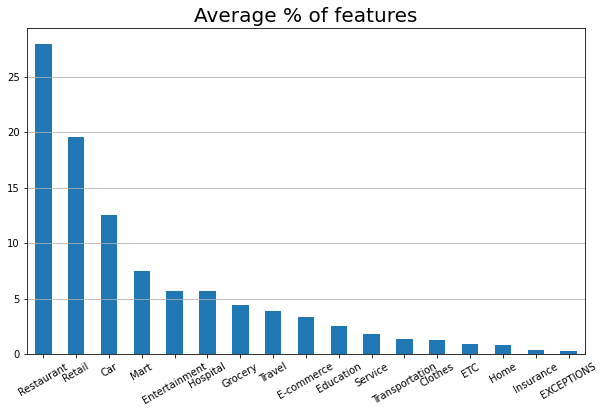

In [ ]:
columns = ['year', 'month', 'region', 'sex', 'age', 'income', 'Home', 'Education', 'Transportation', 'ETC', 
           'Mart', 'Insurance', 'Service', 'Grocery', 'Travel', 'Entertainment', 'Restaurant', 'Hospital', 
           'Clothes', 'Car', 'E-commerce', 'Retail','EXCEPTIONS', 'Sum %', 'pred']
features = ['Home', 'Education', 'Transportation', 'ETC', 
            'Mart', 'Insurance', 'Service', 'Grocery', 'Travel', 'Entertainment', 'Restaurant', 'Hospital', 
            'Clothes', 'Car', 'E-commerce', 'Retail', 'EXCEPTIONS']

df = CSVDATA.copy()
df.columns = columns
means = df[features].mean().sort_values(ascending=False)

plt.rcParams["figure.figsize"] = (10,6)
means.plot(kind='bar')
plt.xticks(rotation=30)
plt.title('Average % of features', size=20)
plt.grid(True, axis='y')

# 2) 클러스터링
- umap(parameter 들 추가가능)
- Dataloder 에서 batch size 잡는거 (너무 크게 잡지않기)
- main에 있는 Autoencoder에서 [열,300, 300 600... ] 300은 똑같이 쓰고 300의 두배정도 값으로 600을 사용 
- train_model -> loss function mse 사용했는데 loss가 잘안줄으면 smoothl Loss 사용
- optimizer에서 adma 잘안되면 AdamW 써보기
- 이외에 바꿔야할것들은 코드에 주석으로 몇개 달음 

In [ ]:
SEED = 2021
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

class creditDataloader(Dataset):
    def __init__(self, csv):

        self.data = csv.iloc[:, 6:22] # 원본데이터는 4:21 ('예외처리' 포함)
        self.data = self.data.to_numpy()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class Autoencoder(nn.Module):
    def __init__(self, numLayers, encoders=False):
        super().__init__()
        self.layers = nn.ModuleList()
        if encoders:
            for i in range(len(numLayers) - 2):
                self.layers.append(nn.Linear(numLayers[i], numLayers[i+1]))
                self.layers.append(nn.ReLU())
            self.layers.append(nn.Linear(numLayers[-2], numLayers[-1]))
        else:
            for i in range(len(numLayers) - 2):
                self.layers.append(nn.Linear(numLayers[i], numLayers[i+1]))
                self.layers.append(nn.ReLU())
            self.layers.append(nn.Linear(numLayers[-2], numLayers[-1]))
            for i in range(len(numLayers) - 1, 1, -1):
                self.layers.append(nn.Linear(numLayers[i], numLayers[i-1]))
                self.layers.append(nn.ReLU())
            self.layers.append(nn.Linear(numLayers[1], numLayers[0]))

    def forward(self, x):
        y = x
        for i in range(len(self.layers)):
            y = self.layers[i](y)
        return y


def Clu_model(hl, cluster):
    hl = hl.cpu().data.numpy()
    hle = umap.UMAP(random_state=20205289, n_components= 2).fit_transform(hl) 
    # clustering on new manifold of autoencoded embedding
    gmm = mixture.GaussianMixture(covariance_type= "full", n_components=cluster, random_state=20205289).fit(hle)
    y_pred_prob = gmm.predict_proba(hle)
    y_predict = y_pred_prob.argmax(1)
    return y_predict, hle

if __name__ == '__main__':

    for cl in [6]: #바꿔봐야할것 
        args = easydict.EasyDict({
            "epochs": 2, # 바꿔봐야할것 
            "ae_weights": None,
            "data": CSVDATA,
            "gpu": 0,
            "n_clusters": cl,
            "batch_size" : 64})  # 바꿔봐야할것 batch : 32 ~ 64

        dataset = creditDataloader(CSVDATA)
        trainLoader = DataLoader(dataset= dataset, batch_size= args.batch_size, shuffle=True, num_workers=16) #num_works = 16
        
        print(trainLoader)
        
        device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
        net = Autoencoder(numLayers=[16, 300, 300, 600, args.n_clusters]) #바꿔봐야할것   # 원본데이터는 16->17 ('예외처리'포함)
        
        optimizer = torch.optim.Adam(net.parameters(), lr= 0.001)   #torch.optim.AdamW(net.parameters(), lr = 0.001)
        net.to(device)

        def train(model, optimizer, loss_fn, train_loader, n_epochs, device):
            for epoch in range(n_epochs):
                loss_train = 0.0
                for data in train_loader:
                    data = data.to(device=device)
                    data = data.view(data.shape[0], -1)
                    data = torch.tensor(data, dtype=torch.float32)
                    outputs = model(data)
                    loss = loss_fn(outputs, data)
                    loss_train += loss.item()
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                if (epoch + 1) % 1 == 0:
                    print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch + 1, loss_train / len(train_loader)))
            return model


        trained_model  = train(net, optimizer, loss_fn= nn.MSELoss(), train_loader= trainLoader, n_epochs= args.epochs, device = device) #Loss : nn.SmoothL1Loss

        encoder = nn.Sequential(*[net.layers[i] for i in range(7)])
        encoder.to(device)
        

        trainloader_GMM = DataLoader(dataset= dataset, batch_size= len(dataset), shuffle=False, num_workers=16)
        for data in trainloader_GMM:
            data = data.to(device)
            data = data.view(data.shape[0], -1)
            data = torch.tensor(data, dtype=torch.float32)
            hl = encoder(data)
            latent = hl.cpu().data.numpy()
            pd.DataFrame(latent).to_csv("latent_{}.csv".format(args.n_clusters))
            pred, hle = Clu_model(hl, args.n_clusters) 

save1 = pd.DataFrame(pred)
save2 = pd.DataFrame(hle)
save1.to_csv(data_dir + 'pred.csv')
save2.to_csv(data_dir + 'hle.csv')

2021-05-25 12:23:22.269444 Epoch 1, Training loss 55.6349359560924
2021-05-25 12:23:25.027326 Epoch 2, Training loss 9.970715660957774


# 3) 시각화

## 2차원 시각화

In [ ]:
""" 클러스터링 2차원 시각화 """

visual = pd.DataFrame(hle)
visual['pred'] = pred

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
visual.plot.scatter(x=0, y=1, c='pred', colormap='viridis')

NameError: ignored

## bar plot
- 전체 feature 평균값 비교

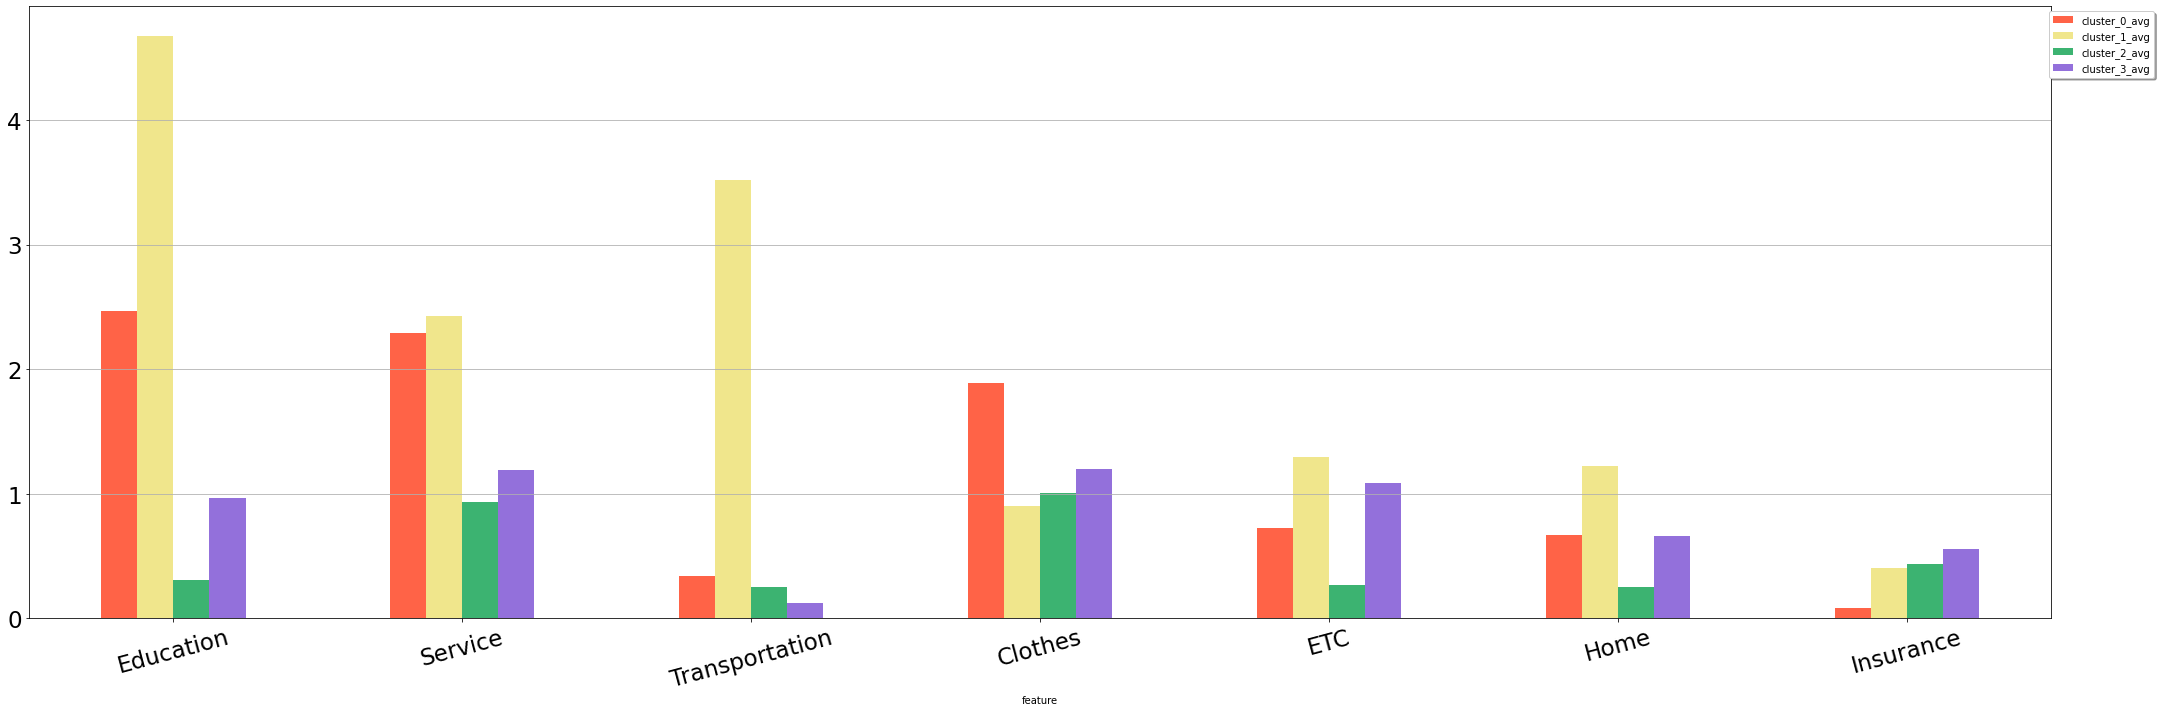

In [ ]:
import matplotlib.pyplot as plt
import collections
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import font_manager, rc

def stat_summary(df, feature):
    
    df_avg = df.groupby('pred').mean()
    df_std = df.groupby('pred').std()
    
    df_avg = df_avg[feature] ; df_avg = df_avg.T
    df_std = df_std[feature] ; df_std = df_std.T

    pre = list(df_avg.columns)
    predict = []
    for i in range(len(df_avg.columns)):
        for j in range(len(list(df_avg.index))):
            i = str(i)
            predict.append(i)

    col = list(df_avg.index)
    col = col*len(df_avg.columns)

    """avg, sd 칼럼 리스트"""
    avg_list = []
    for i in range(len(df_avg.columns)):
        for j in range(len(list(df_avg[i]))):
            avg_list.append(df_avg[i][j])
    std_list = []
    for i in range(len(df_std.columns)):
        for j in range(len(list(df_std[i]))):
            std_list.append(df_std[i][j])

    dfdf = pd.DataFrame()
    dfdf['predict'] = predict
    dfdf['column_name'] = col
    dfdf['avg'] = avg_list
    dfdf['std'] = std_list
    
    return dfdf

def error_bar(df, feature):
    
    df = stat_summary(df, feature)
    
    """1)각 클러스터"""
    df['predict'] = df['predict'].astype(int)
    predict_dict = collections.Counter(df['predict'])
    predict_list = list(predict_dict.keys())
    column_dict = collections.Counter(df['column_name'])
    column_list = list(column_dict.keys())
    clusters={}
    for x in range(len(predict_list)):
        clusters["{0}".format(x)] = df[df['predict']==predict_list[x]]
    avg_dict = {}
    error_dict = {}
    for key in clusters.keys():
        avg_dict['{0}'.format(key)] = list(clusters[key]['avg'])
        error_dict['{0}'.format(key)] = list(clusters[key]['std'])
    labels = column_list
    x_pos = np.arange(len(labels))
        
    """2)모든 클러스터"""
    plt.rcParams["figure.figsize"] = (30,10)
    df = pd.DataFrame()
    df['feature'] = column_list
    for i in predict_list:
        df['cluster_{0}_avg'.format(i)] = avg_dict[str(i)]
        df['cluster_{0}_sd'.format(i)] = error_dict[str(i)]
    avg_list = [] 
    for i in range(len(predict_list)):
        avg_list.append('cluster_{0}_avg'.format(i))
    sd_list = []
    for i in range(len(predict_list)):
        sd_list.append('cluster_{0}_sd'.format(i))
    #tab20c
    ax = df.plot.bar(x = 'feature',
                     y = avg_list,
                     #yerr = df[sd_list].T.values, # error bar 표시
                     rot=15, fontsize=23, ecolor='lightgrey', #capsize=7,
                     color=tuple(['tomato', 'khaki', 'mediumseagreen', 'mediumpurple', "mediumorchid",  "silver", "palegreen", 'olive'])) 
                                  
#     ["dodgerblue", "deepskyblue", "lightskyblue", "lightblue", "paleturquoise",
#     "sienna", "orangered", "tomato", "coral", "darksalmon", "salmon", "lightsalmon", "mistyrose",
#     "darkgreen", "green", "seagreen", "mediumseagreen", "darkseagreen", "lightgreen", "palegreen",
#     "rebeccapurple", "blueviolet", "darkorchid", "mediumorchid", "mediumpurple", "plum", "thistle",
#     "dimgrey", "grey", "darkgrey", "silver", "lightgrey", "whitesmoke"
#     'darkgoldenrod','goldenrod','olive','darkkhaki', 'gold' ,'khaki']
     

    ax.legend(loc='upper center', bbox_to_anchor=(1.025, 1),
              ncol=1, fancybox=True, shadow=True)
    ax.yaxis.grid(True)
    plt.tight_layout()
    #plt.savefig('error_bar_{0}.png'.format(feature[0]), dpi=300)
    #plt.savefig('error_bar_all.png', dpi=300)
    plt.show()


""" 실행 """

df = CSVDATA.copy()
# 전체
feature = ['Restaurant', 'Retail', 'Car', 'Mart', 'Fun', 'Hospital', 'Grocery', 'Travel', 'E-commerce', 'Education', 'Service', 'Transportation', 'Clothes', 'ETC', 'Home', 'Insurance']
# 10%이상
feature_1 = ['Restaurant', 'Retail', 'Car']
# 3% 이상
feature_2 = ['Mart', 'Fun', 'Hospital', 'Grocery', 'Travel', 'E-commerce']
# 2% 이하
feature_3 = ['Education', 'Service', 'Transportation', 'Clothes', 'ETC', 'Home', 'Insurance']
error_bar(df, feature_3)

## error bar
- 각 feature 별 비교 (1-sigma)

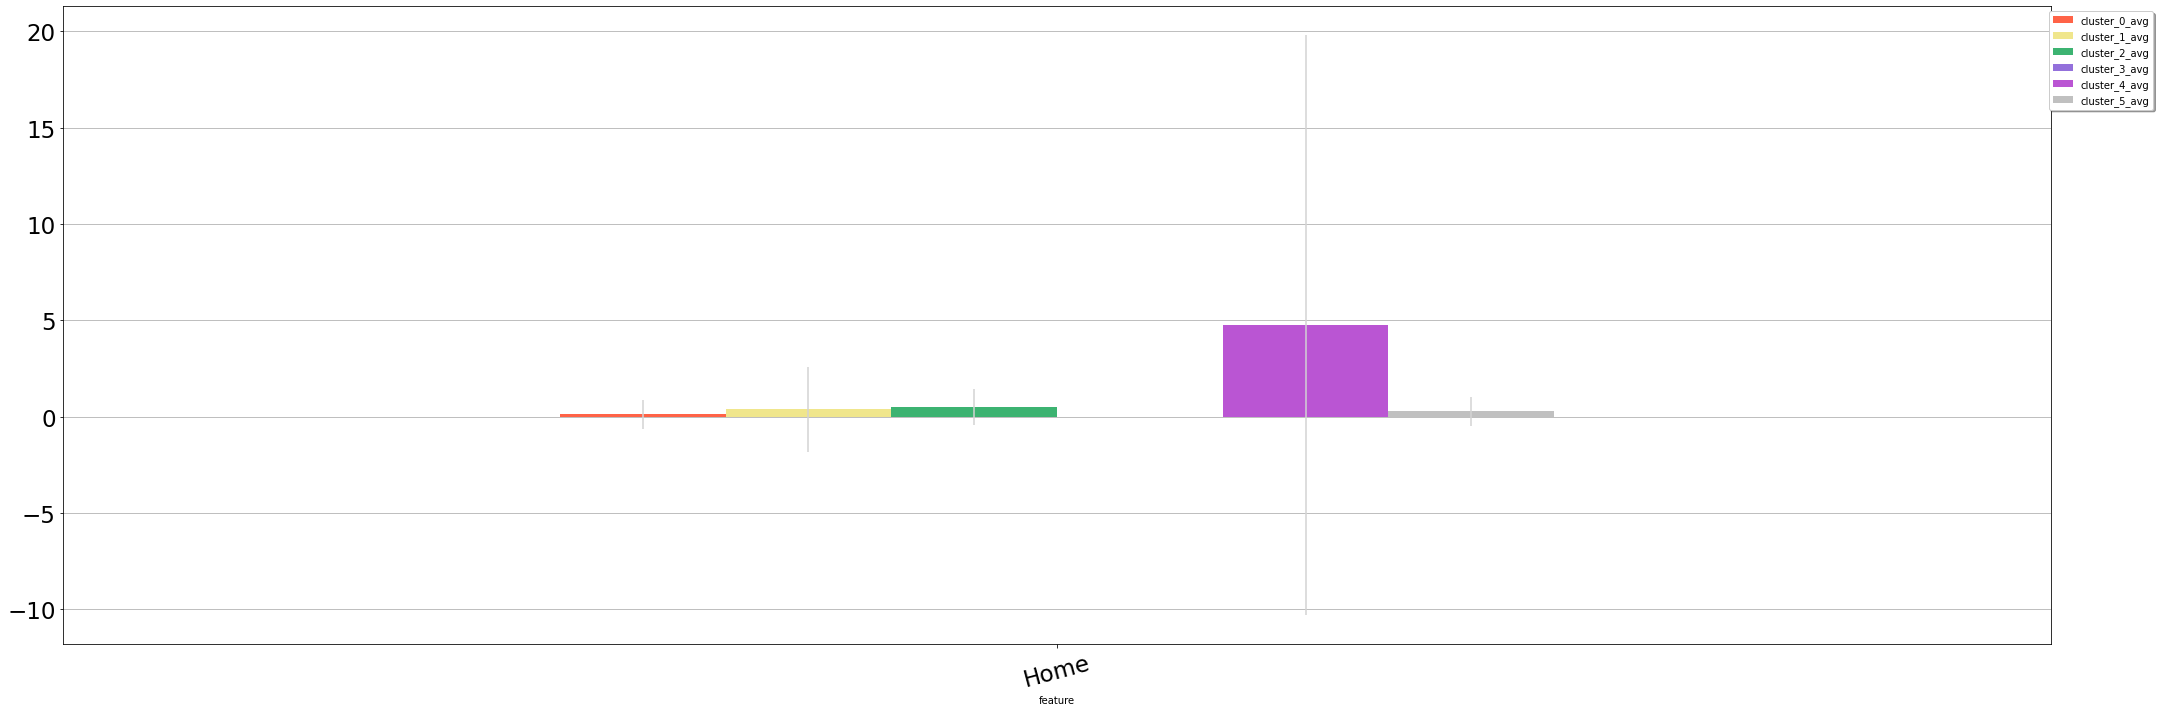

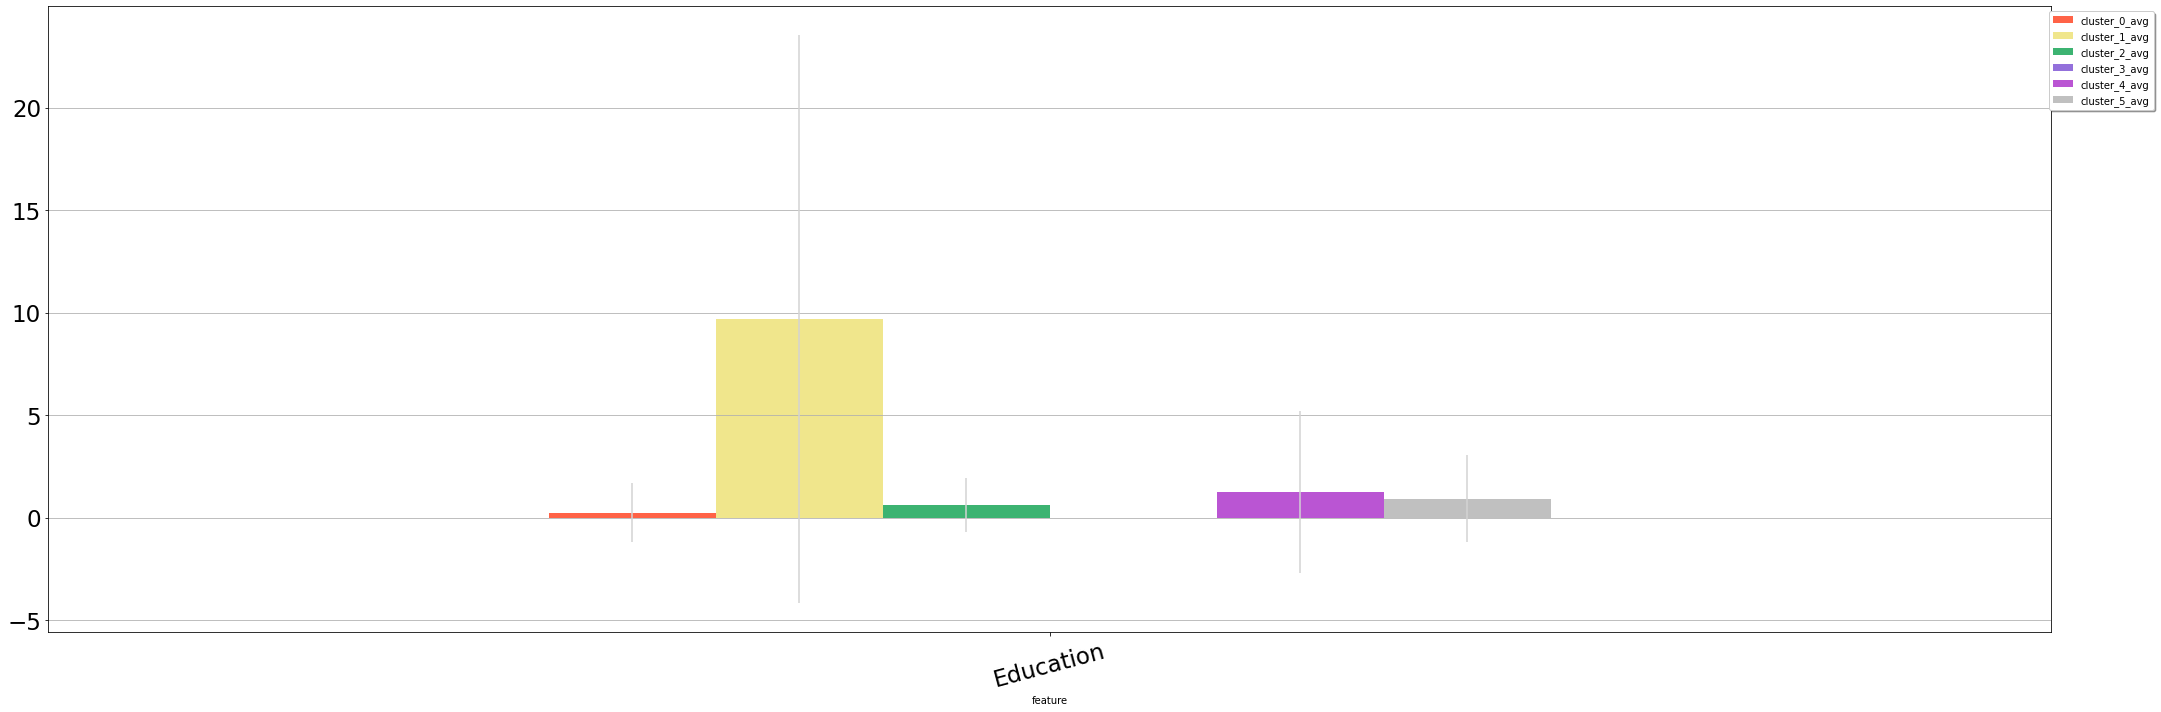

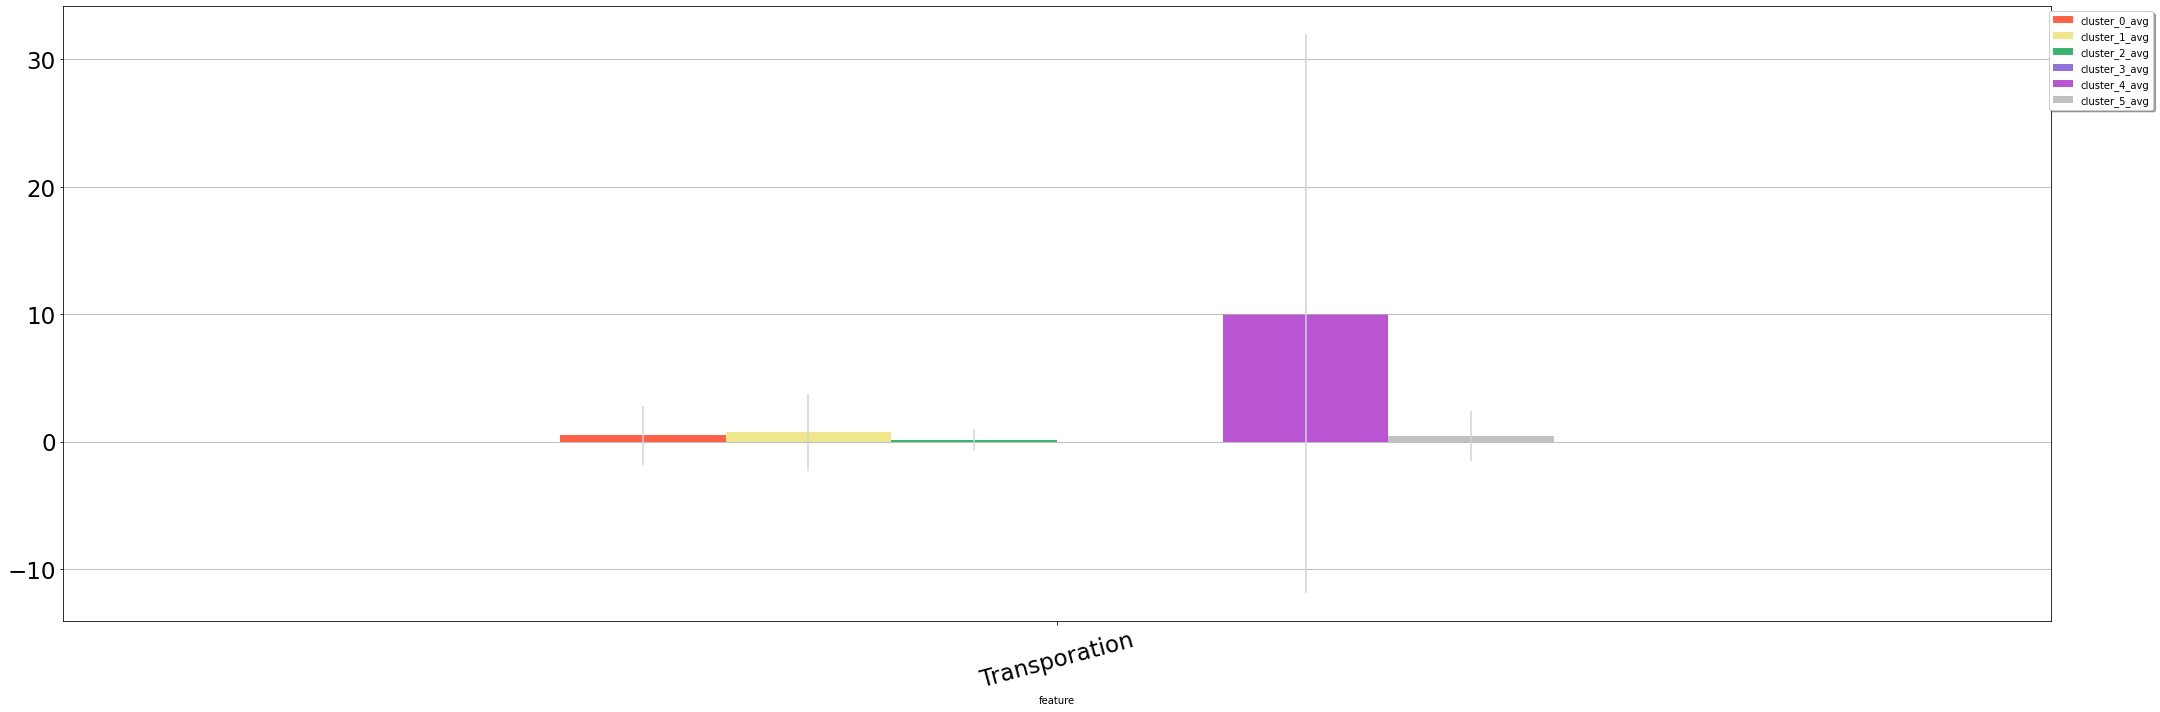

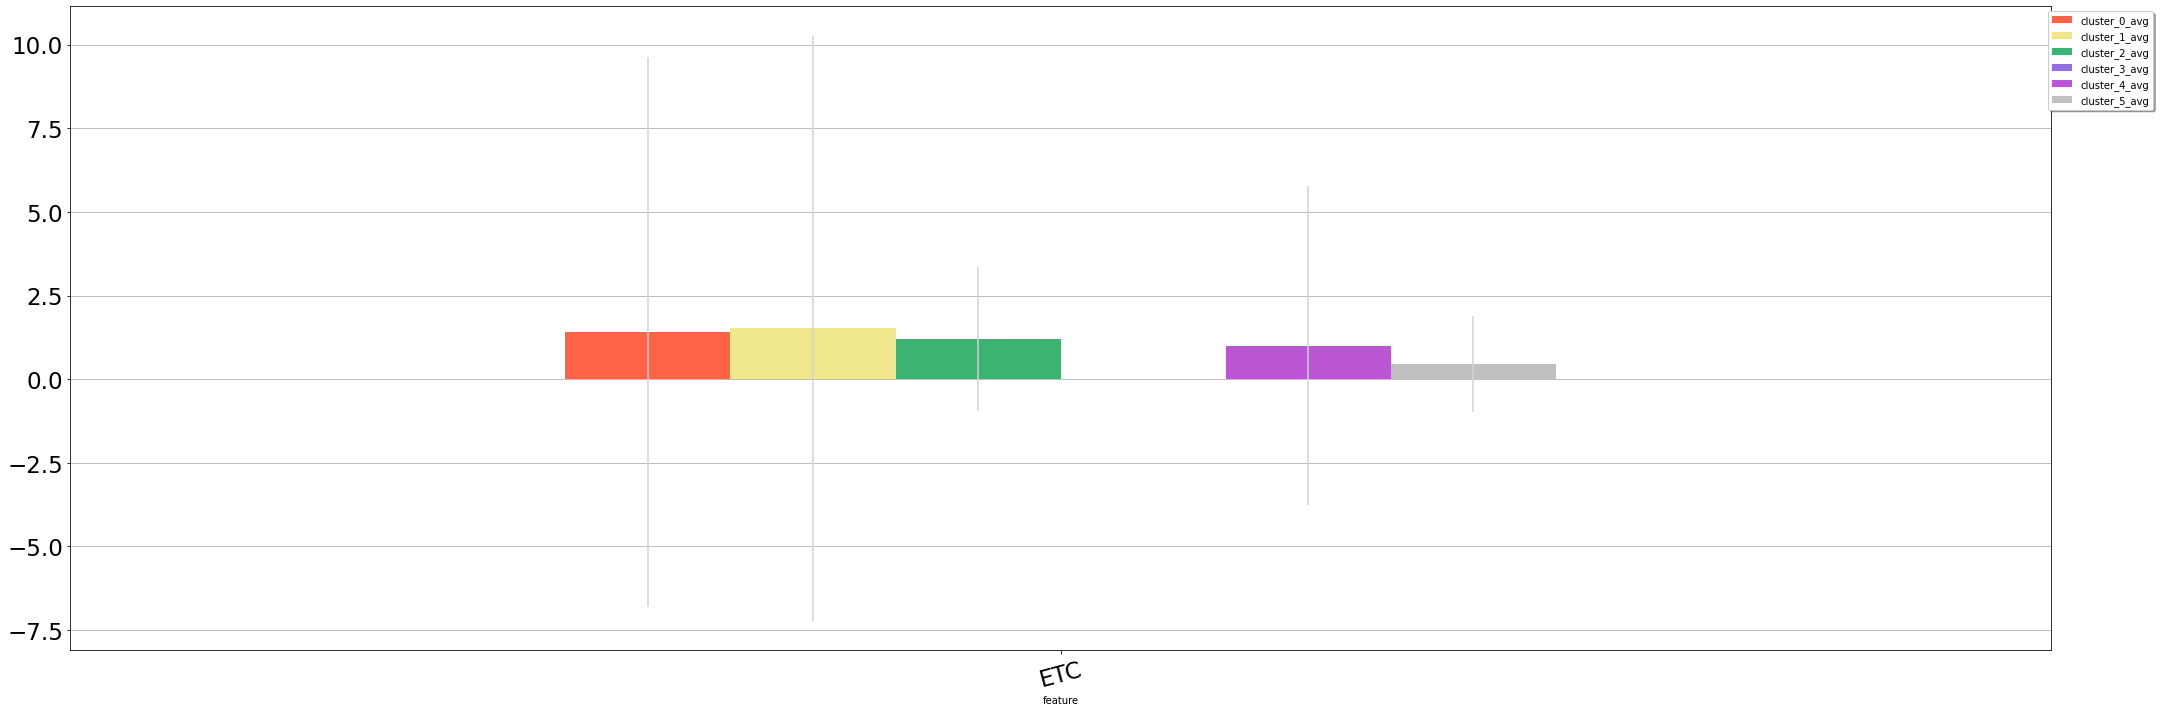

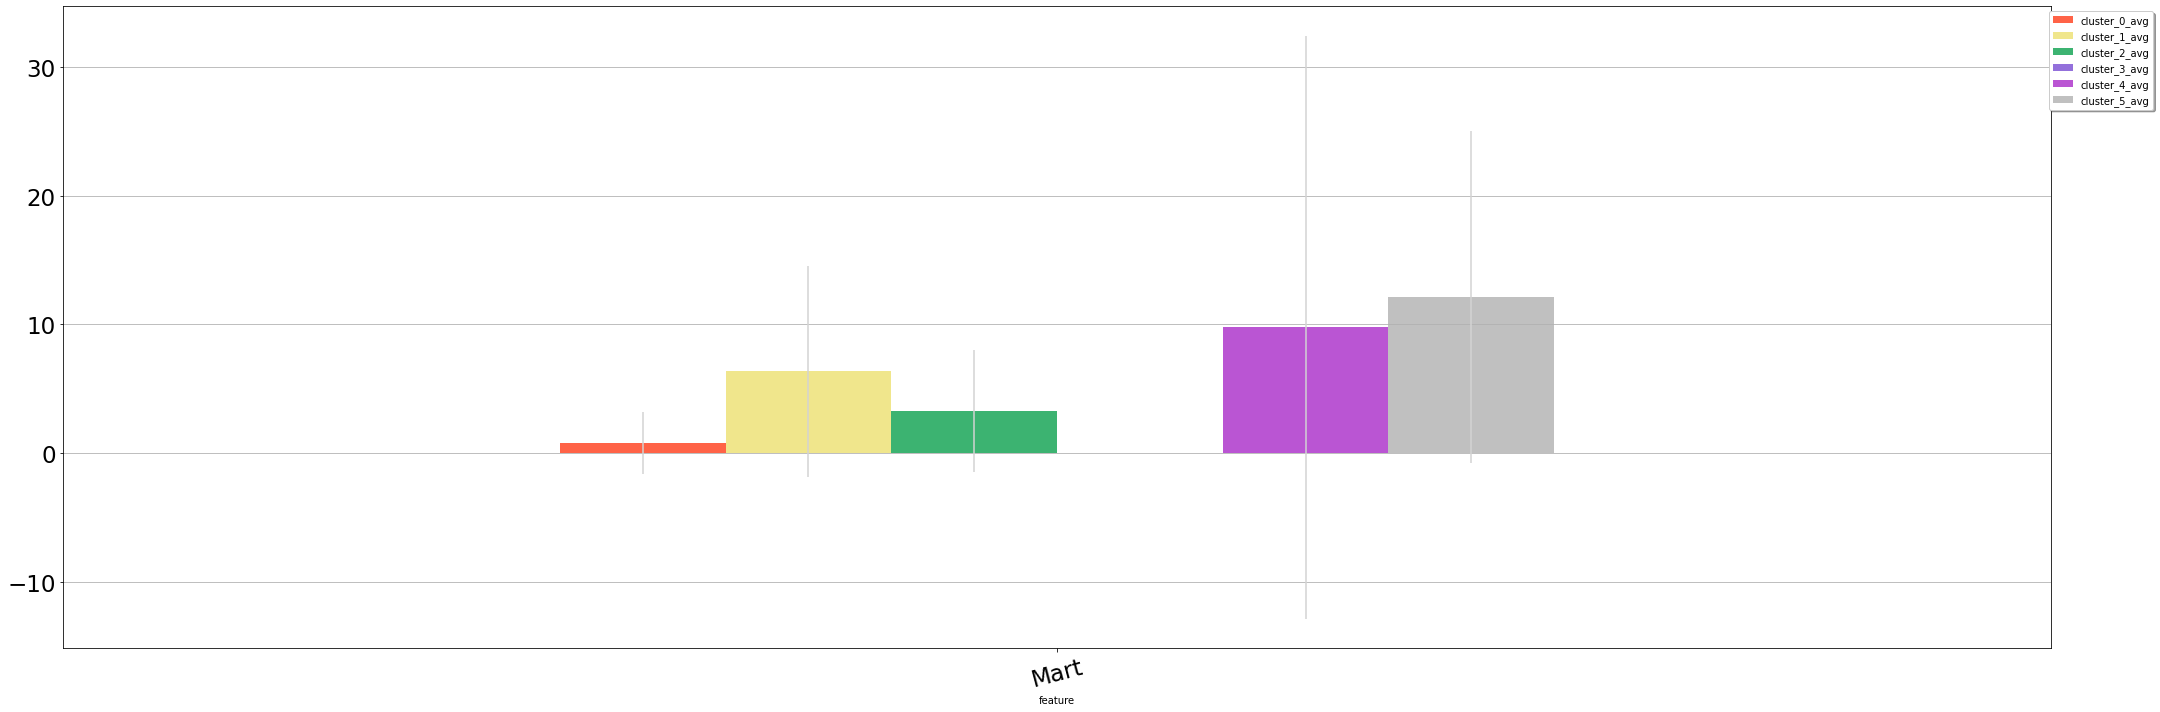

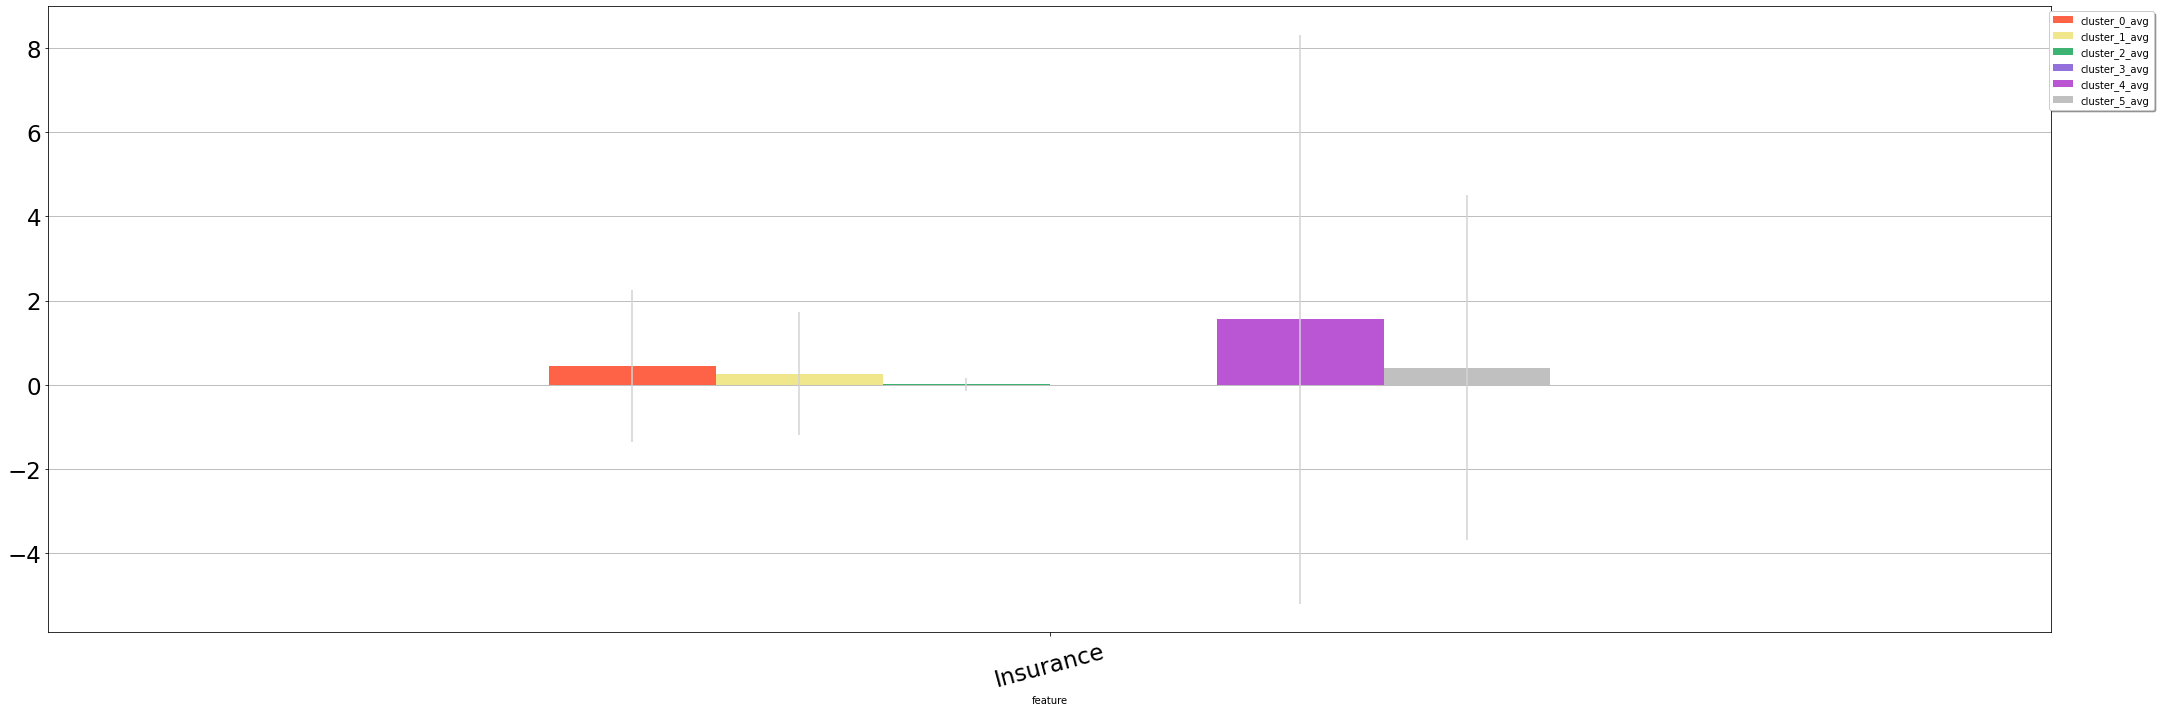

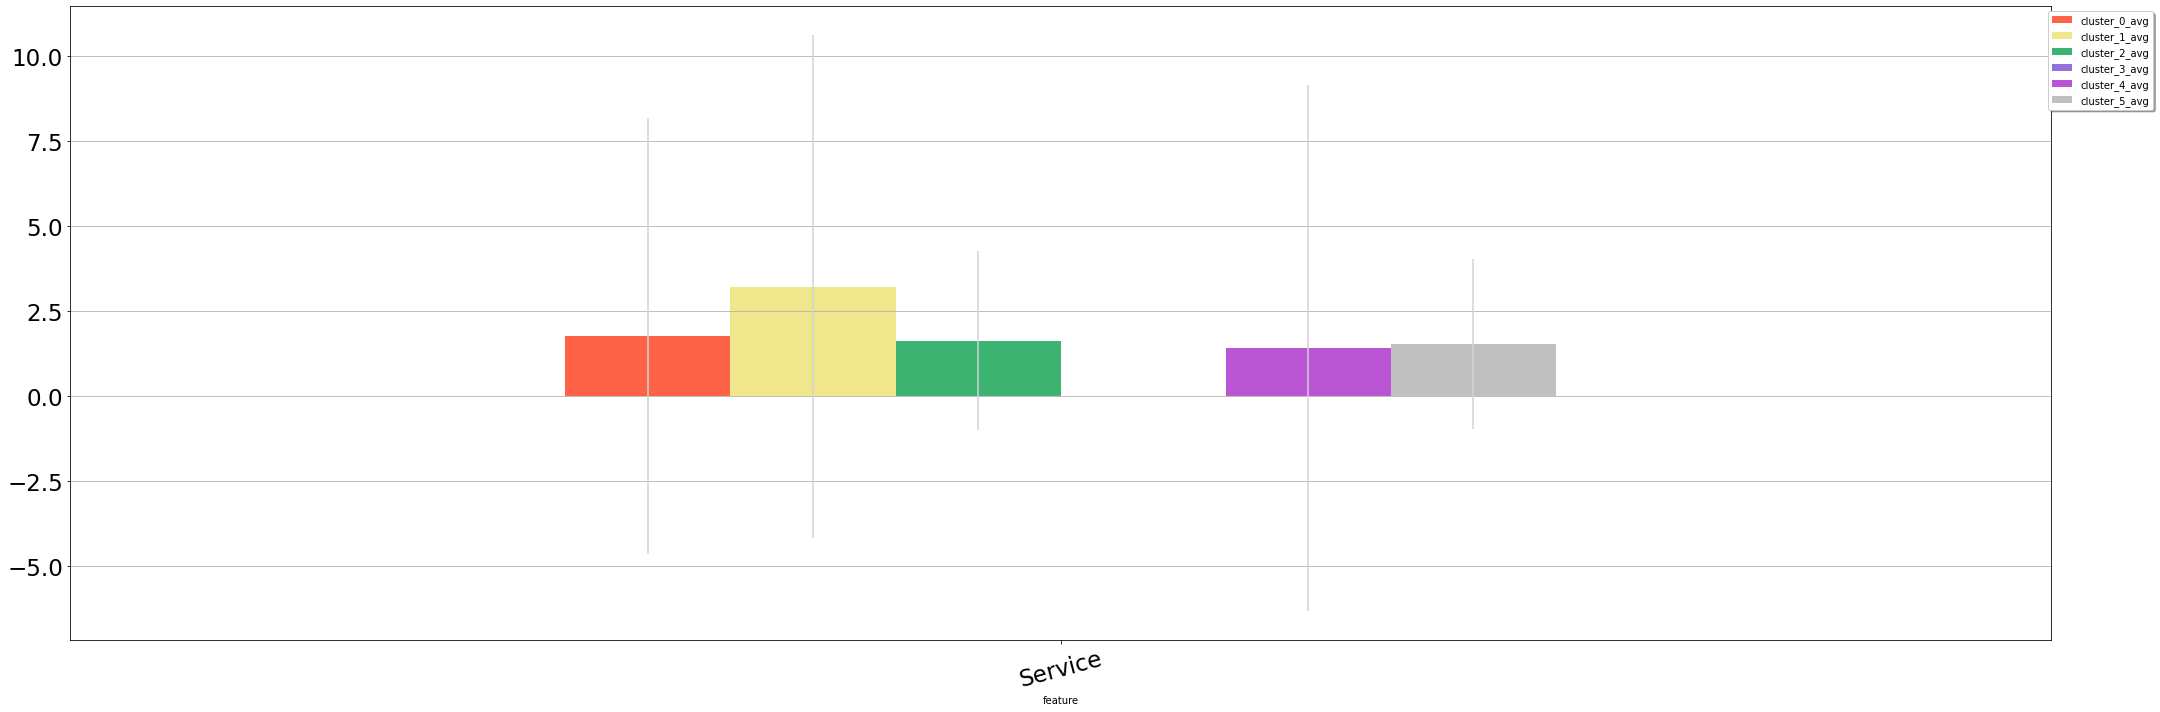

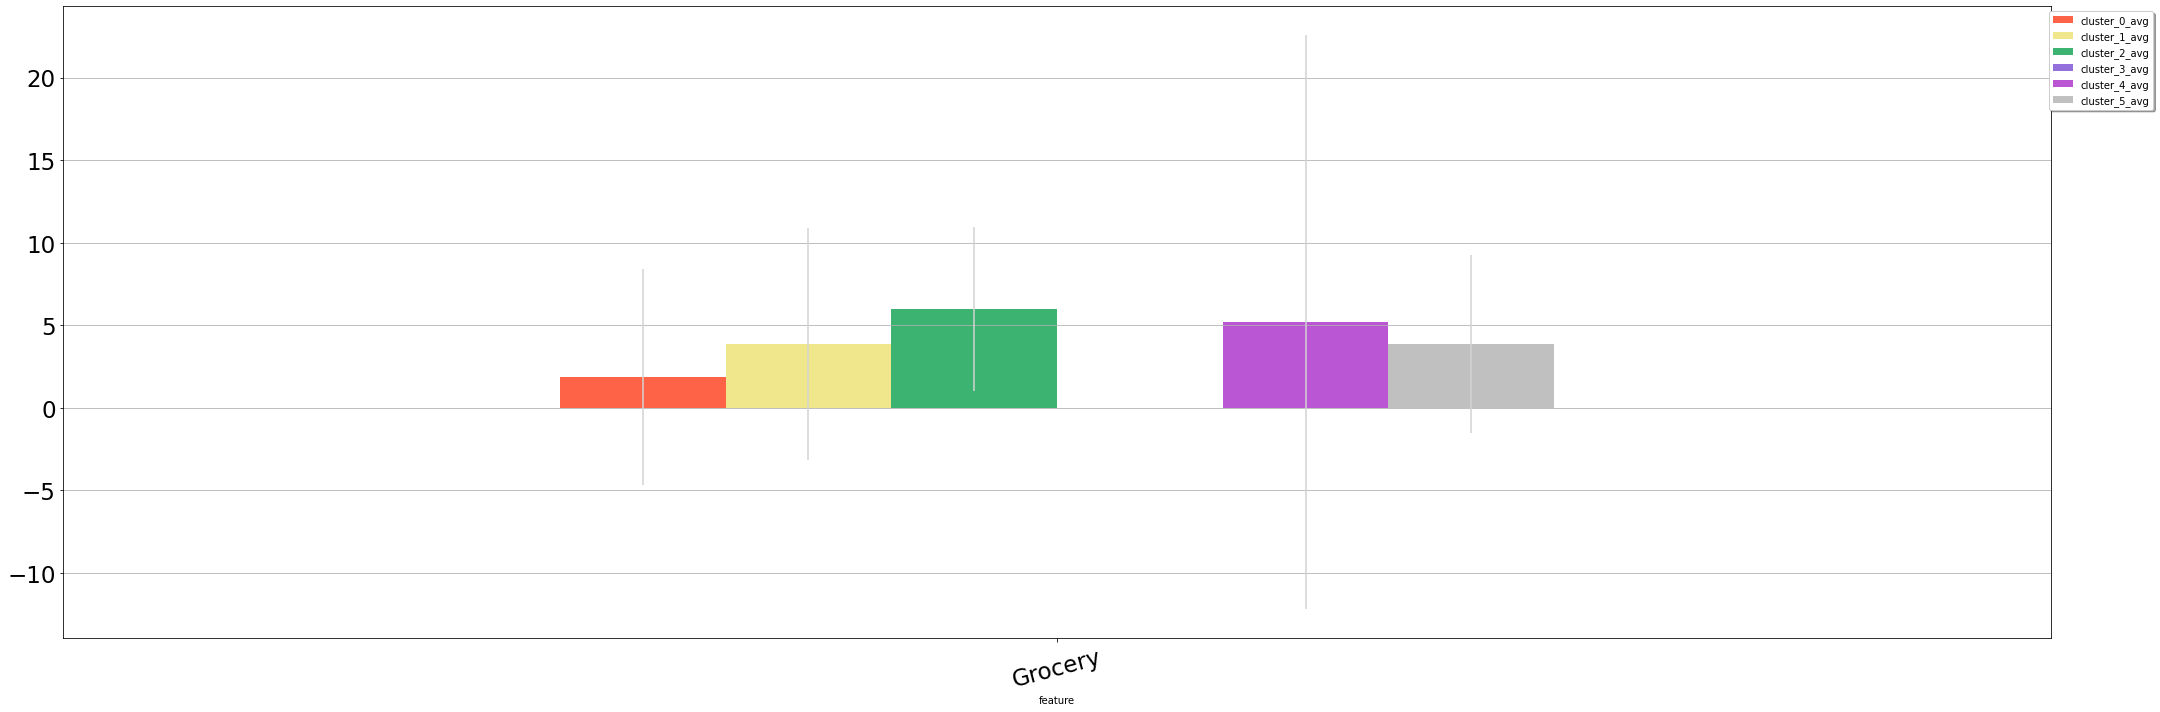

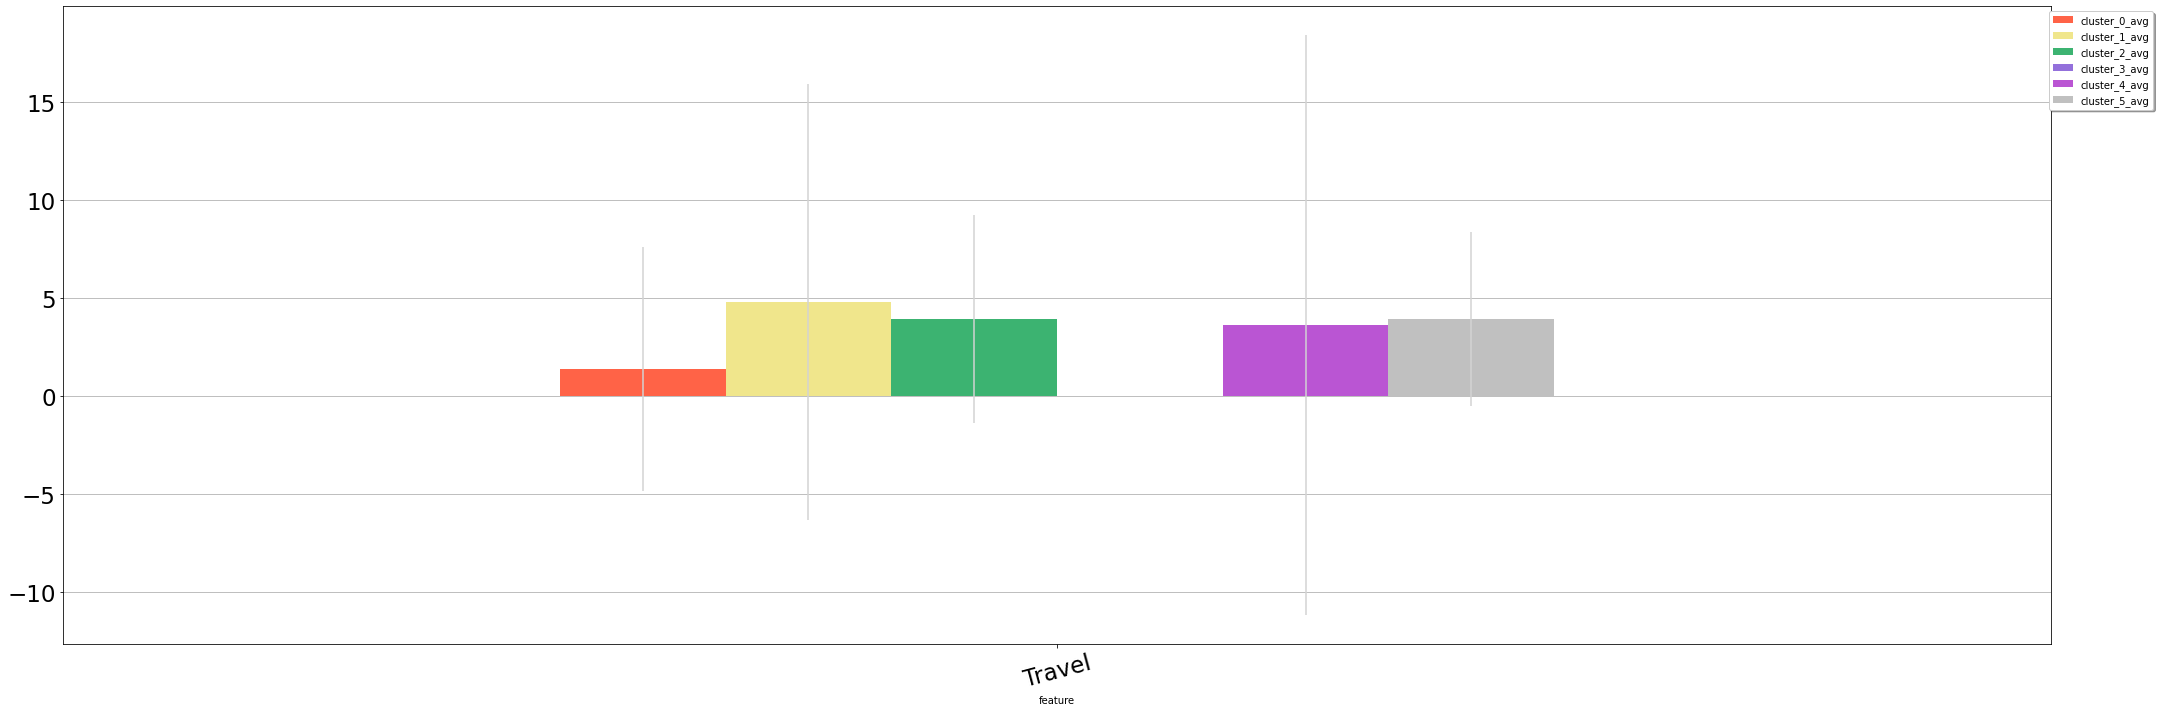

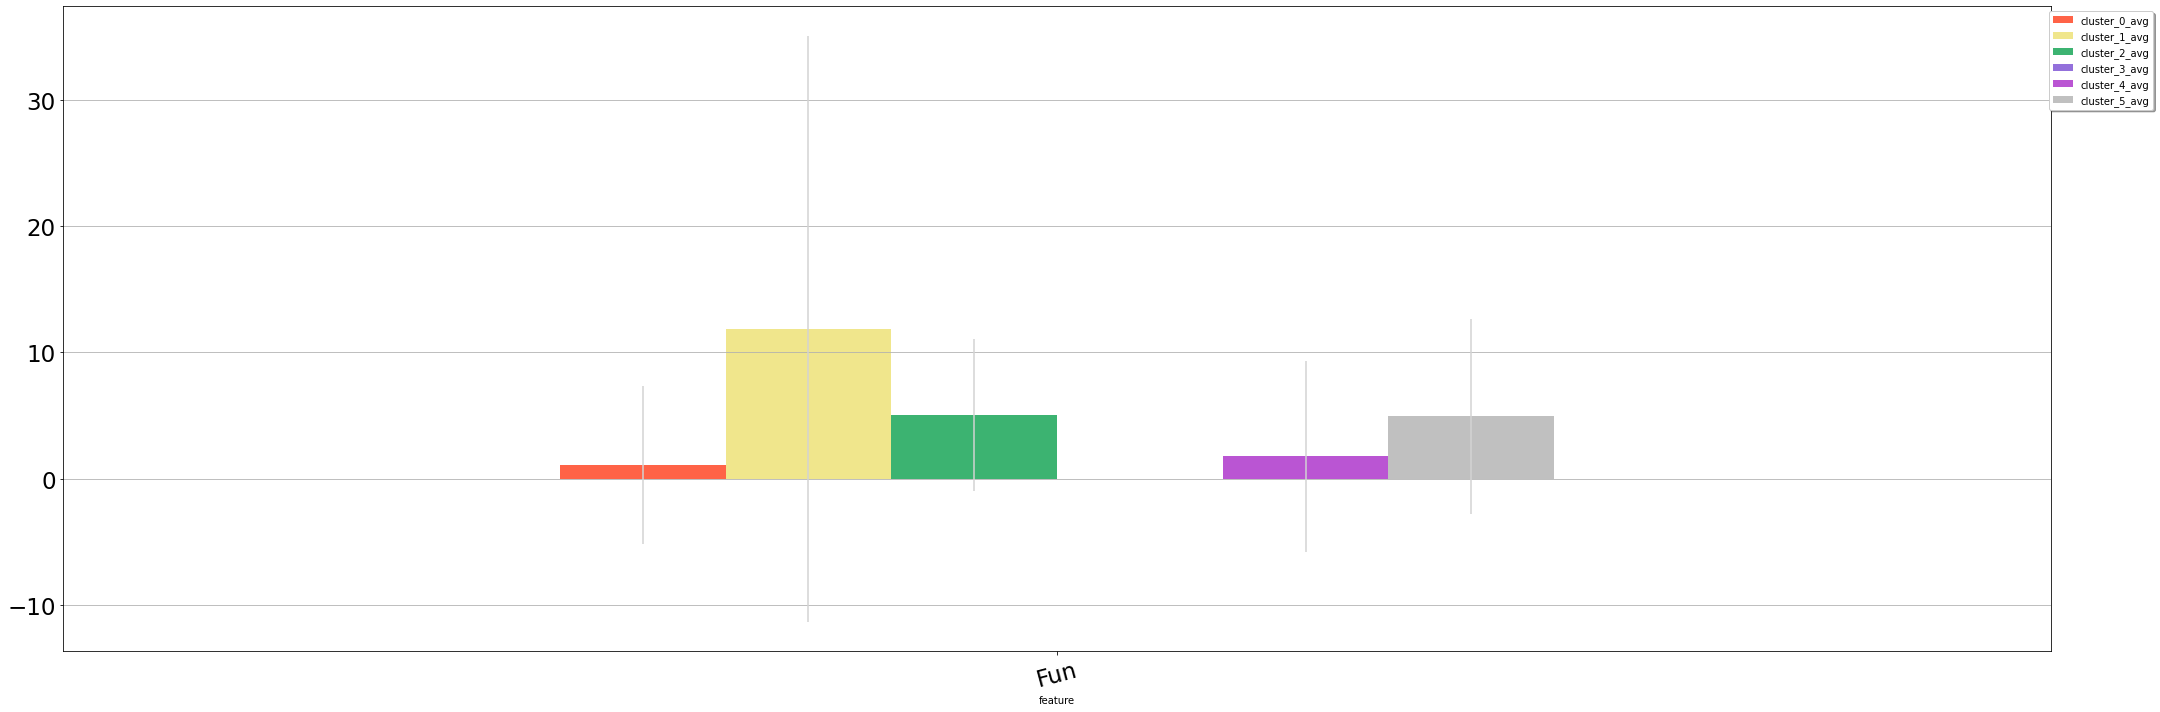

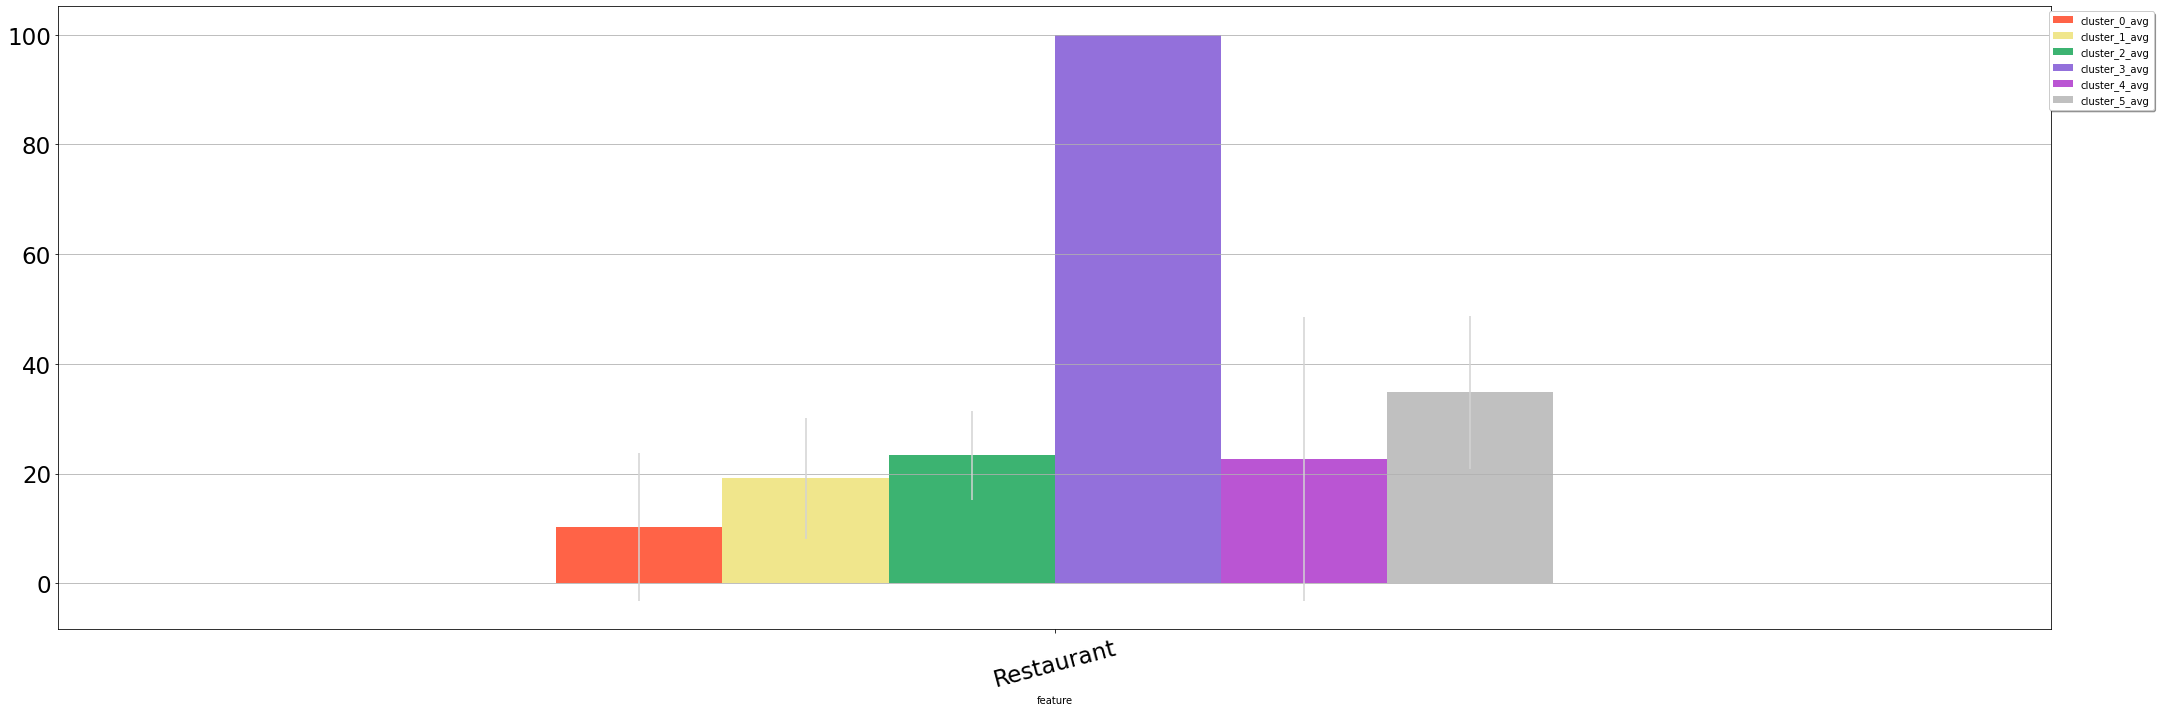

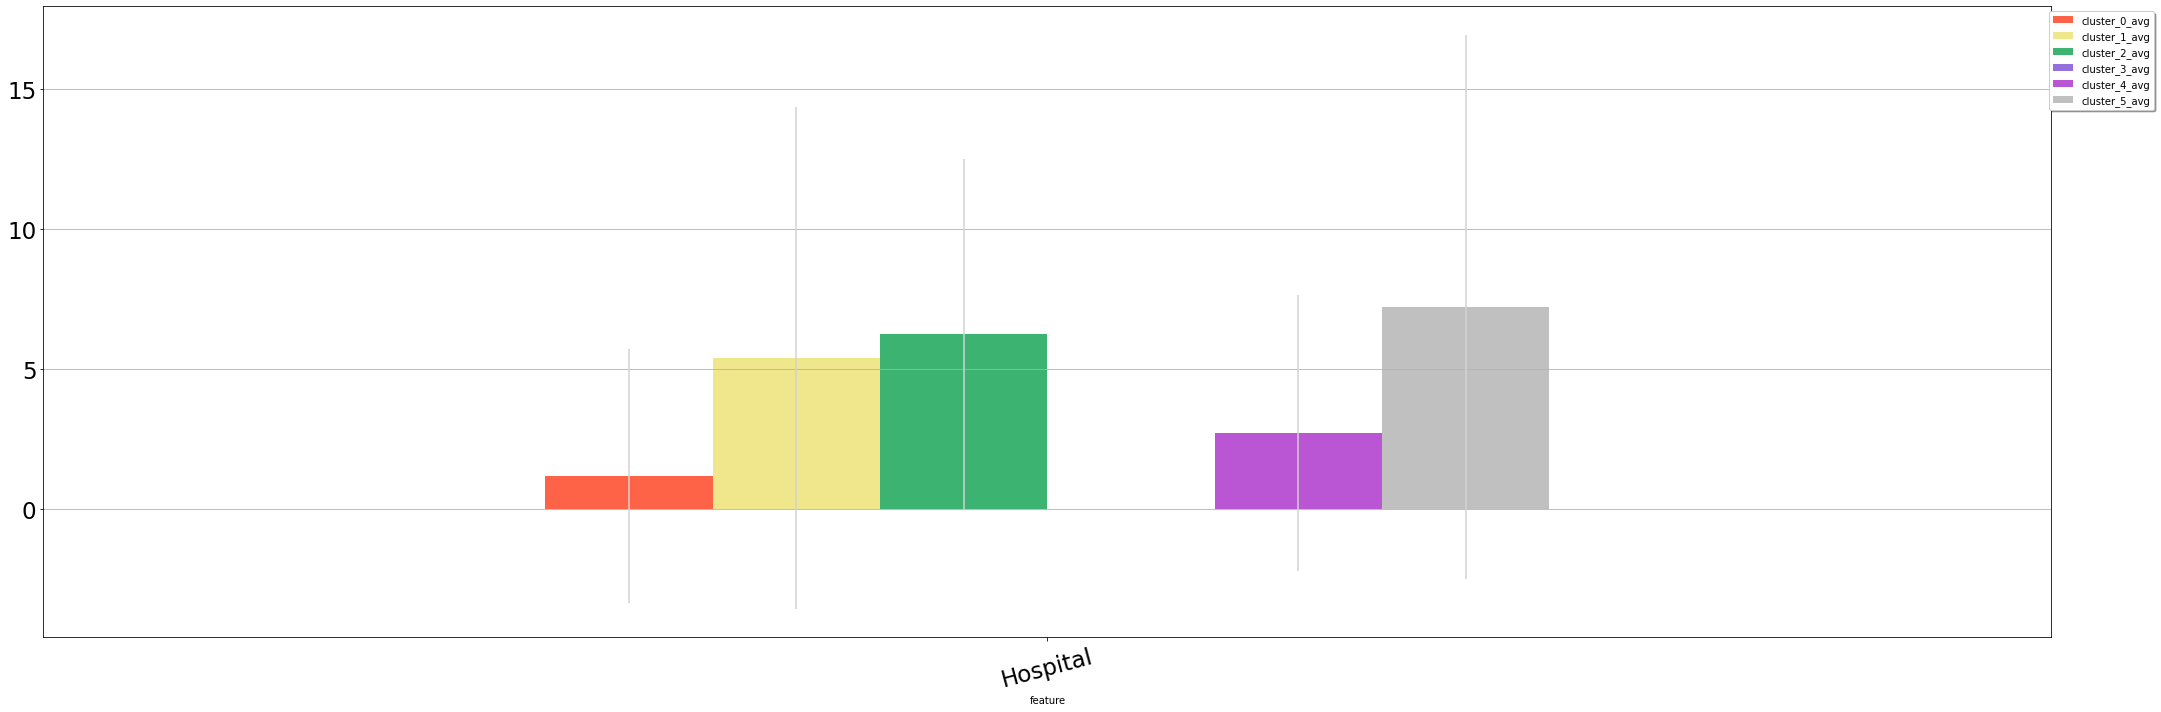

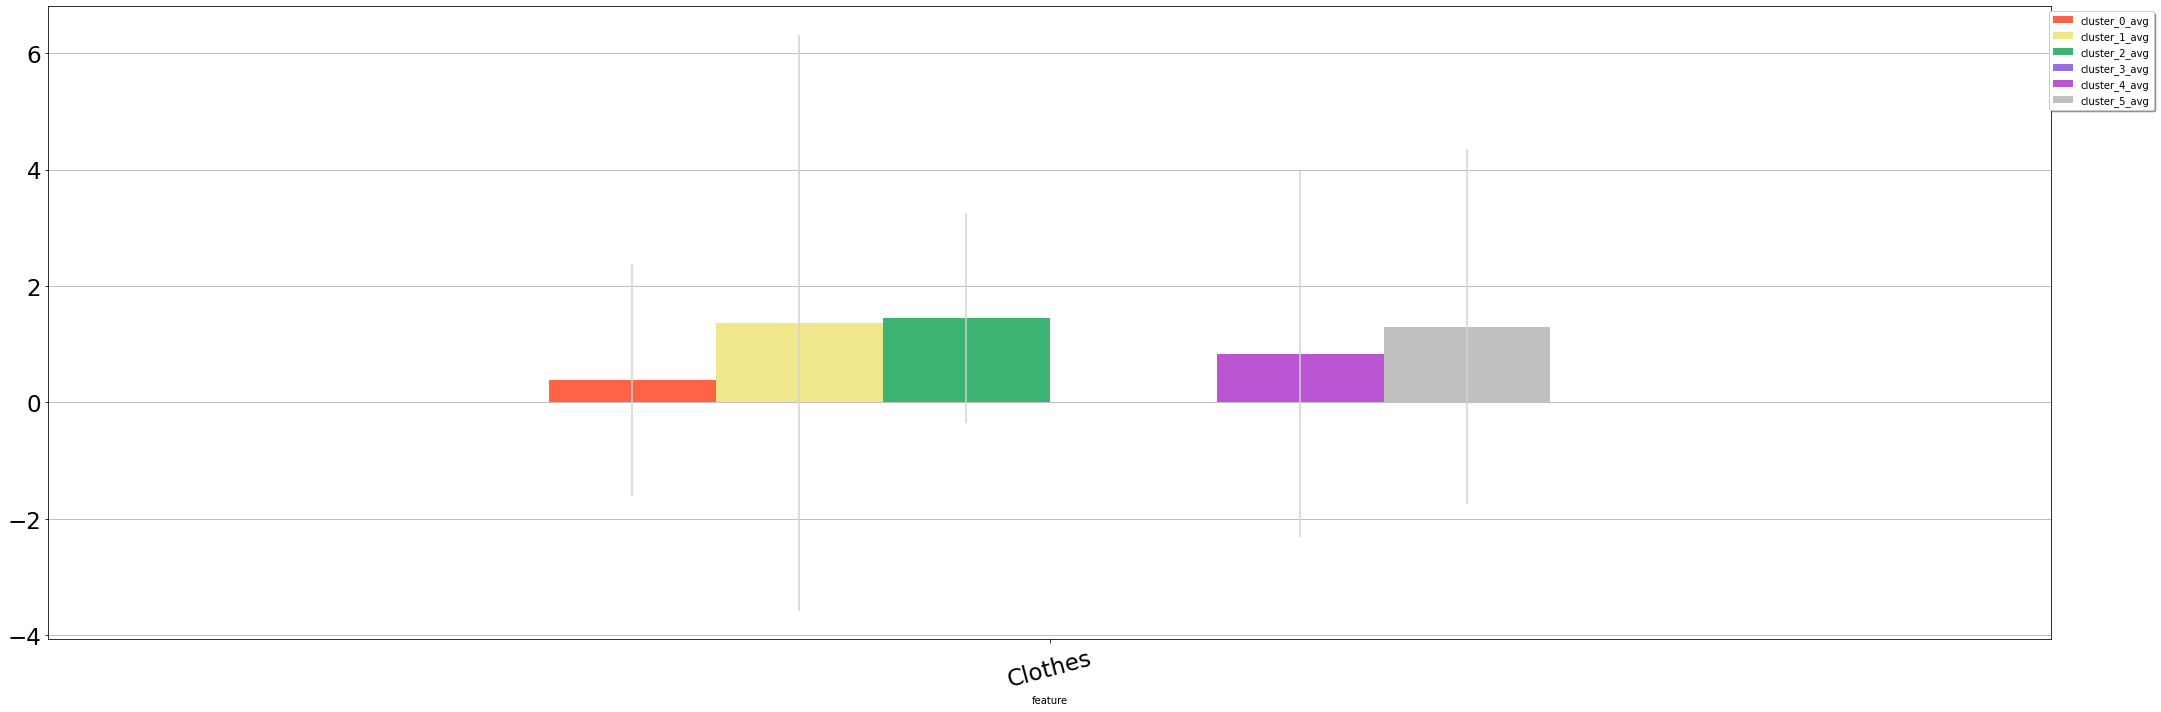

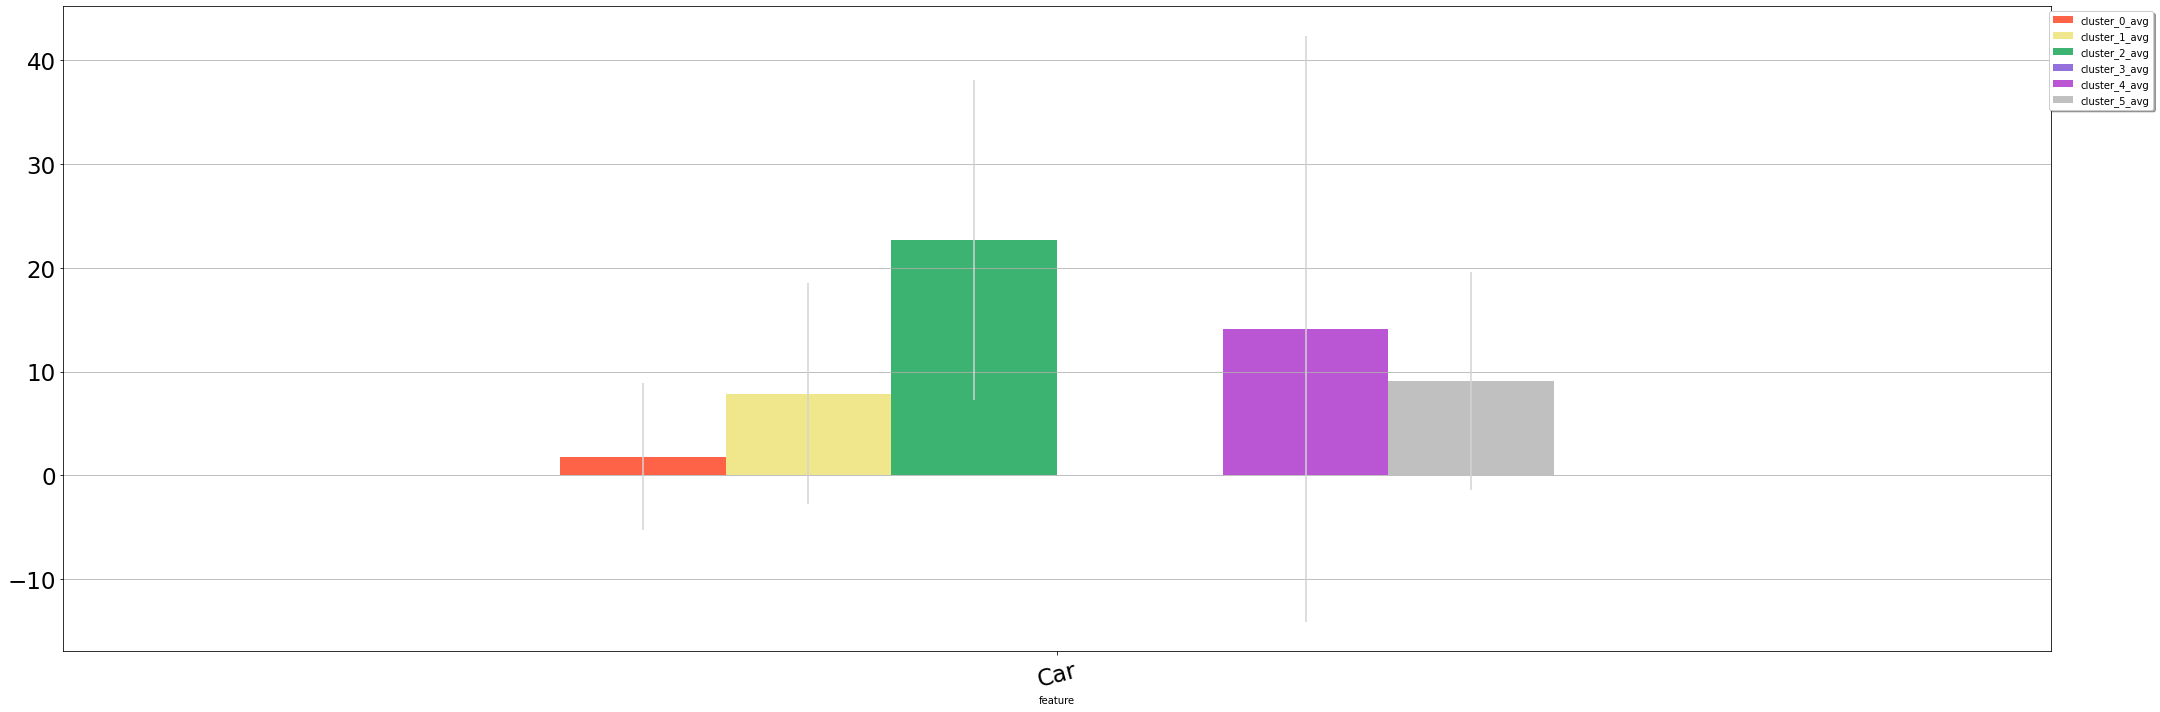

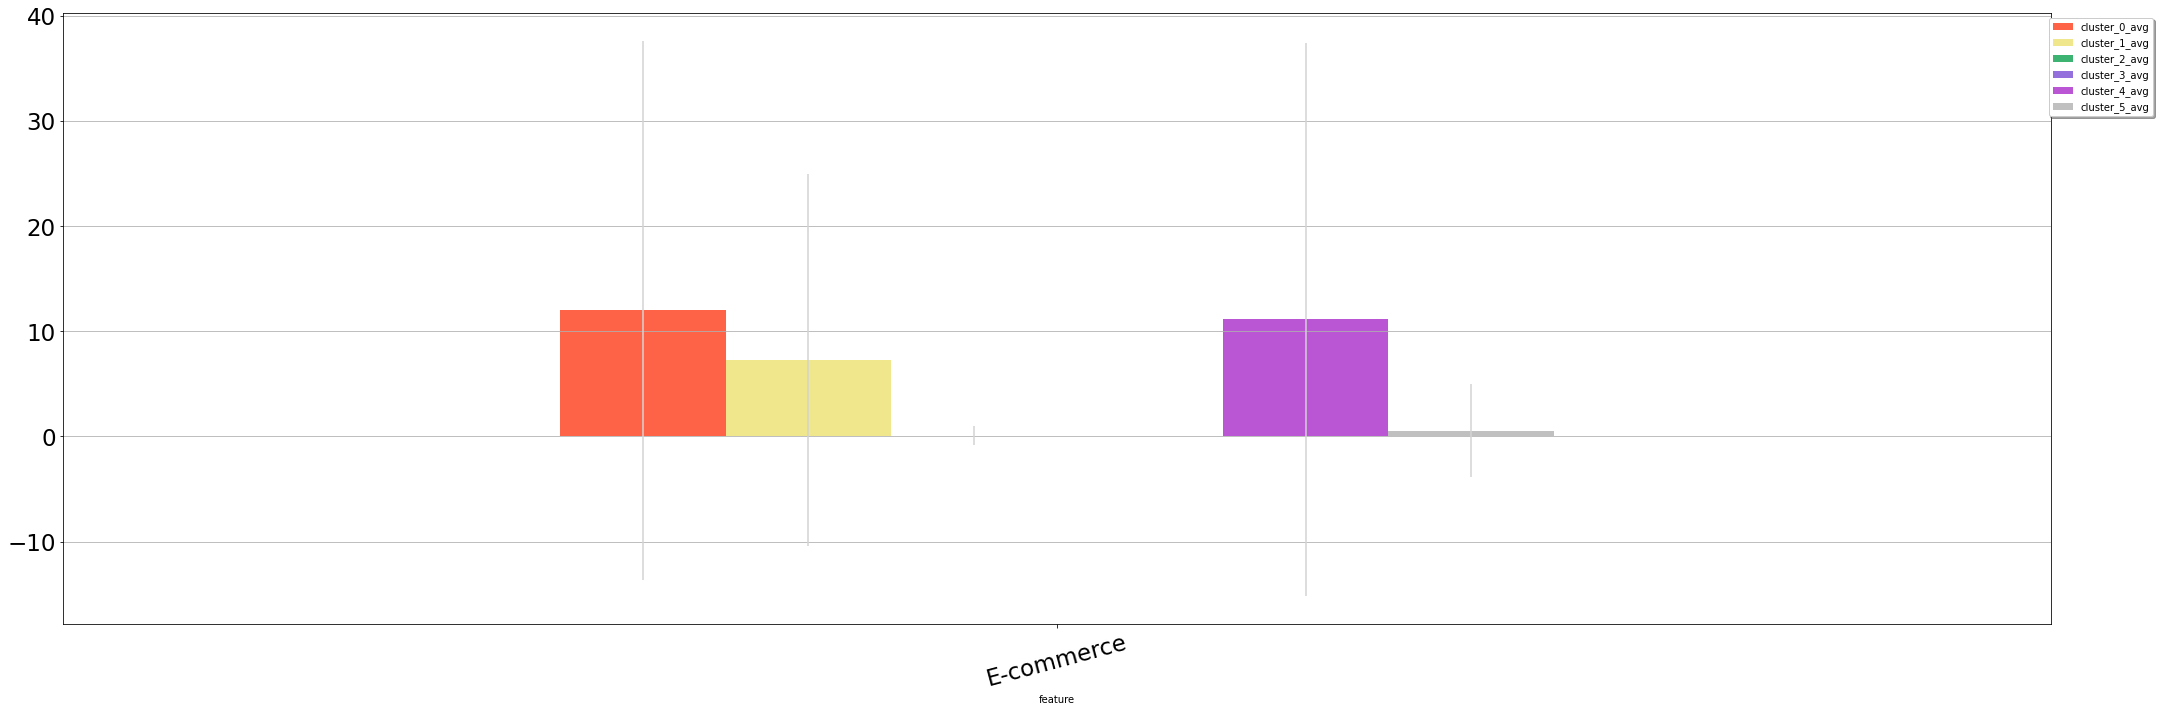

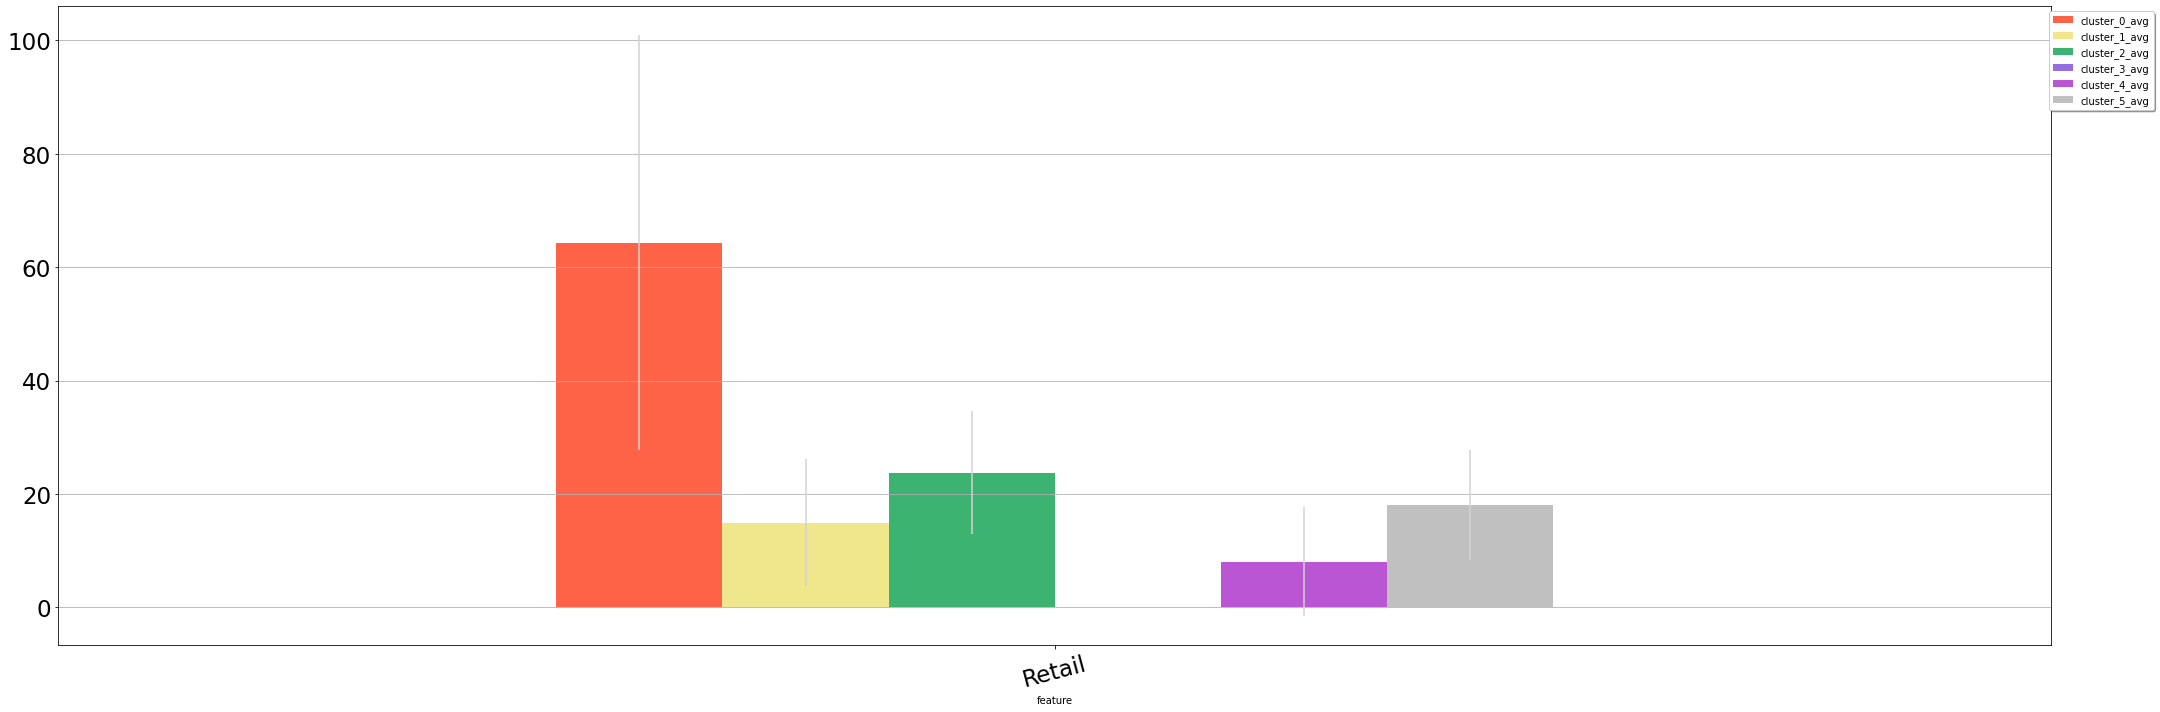

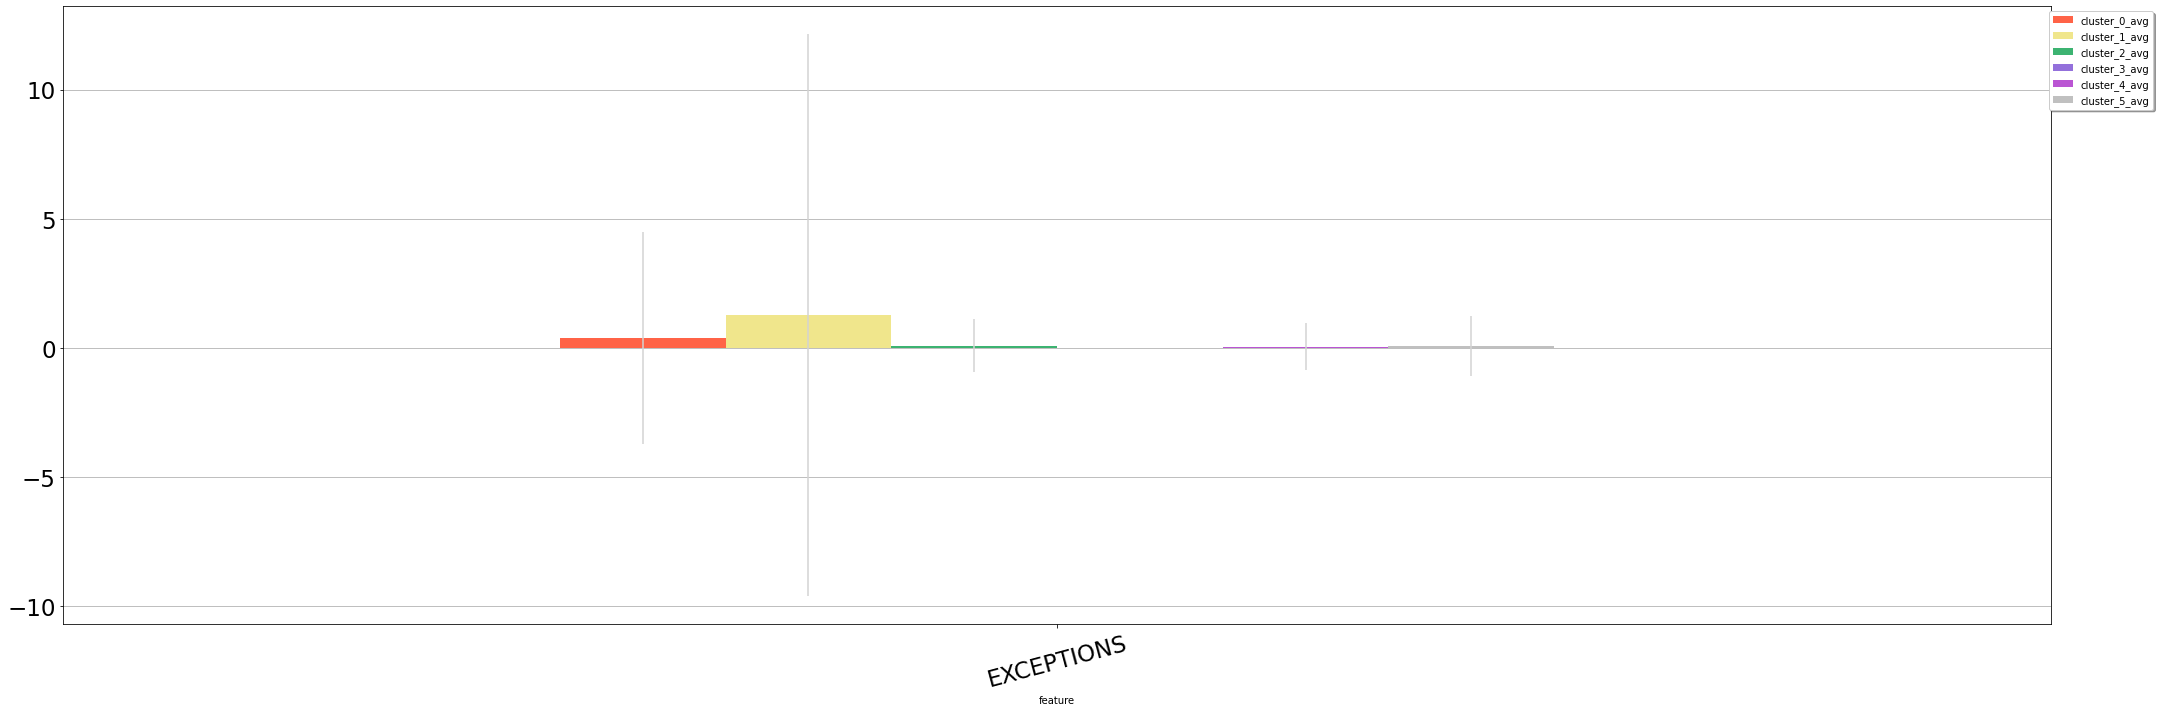

In [ ]:
""" 실행 """

for i in range(len(feature)):
    feature_list=[]
    feature_list.append(feature[i])
    error_bar(df, feature_list)

## box plot

In [14]:
CSVDATA['pred'].value_counts()

3    68695
1    63624
5    57314
0    36245
2    21050
6    10370
4     7196
7     4234
Name: pred, dtype: int64

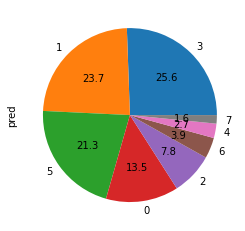

In [15]:
CSVDATA['pred'].value_counts().plot.pie(autopct='%.1f')

In [16]:
""" 캡씌우기: max cap = q3 + 0.1 """

df = CSVDATA.copy()

preds = list(df['pred'].unique())
feature = ['Restaurant', 'Retail', 'Car', 'Mart', 'Entertainment', 'Hospital', 'Grocery', 'Travel', 'E-commerce', 'Education', 'Service', 'Transportation', 'Clothes', 'ETC', 'Home', 'Insurance']

all_data = []
for i in preds:
  temp = df[df['pred'] == i]
  for f in feature:
    q3 = float(temp[f].quantile([0.75]))
    temp[f] = temp[f].clip(upper = q3+0.1)
  all_data.append(temp)

df = pd.concat(all_data, axis=0, ignore_index=True)
df.shape

(268728, 25)

In [17]:
import plotly.graph_objects as go

def boxplot(df, feature):
    
    global k
    k=5
    
    box_list = []
    for i in range(len(feature)):
        box_list.append(feature[i])
        
    numberofcluster = list(df.groupby('pred').size())
    
    x_list = []
    x = []
    for i in numberofcluster: 
        for j in box_list:
            j = j+' '
            temp = j*i
            x.extend(temp.split()) 
        x_list.append(x)
        x = []
    
    y_list = []
    y = []
    for name,group in df.groupby('pred'):
        for j in box_list:
            y.extend(group[j])
        y_list.append(y)
        y = []
    
    fig = go.Figure()
    N=k*len(feature)
    #color = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 3000, N)]
    color = [ 'tomato', 'goldenrod','lightseagreen','slateblue', 'plum', 'black',"forestgreen", "lightgrey"]
    """
                     'tomato',
                    'darkorange', 'sandybrown', 'peachpuff',
                    'goldenrod', 'gold', 'khaki',
                    'forestgreen', 'limegreen',
                    'lightseagreen', 'turquoise', 'aquamarine',
                    'steelblue', 'deepskyblue', 'skyblue', 'powderblue',
                    'slateblue',
                    'darkviolet', 'mediumorchid', 'plum','thistle',
                    'dimgrey', 'darkgrey', 'lightgrey',
                    "sienna", "orangered", "tomato", "coral", "darksalmon", "salmon", "lightsalmon", "mistyrose",
#     "darkgreen", "green", "seagreen", "mediumseagreen", "darkseagreen", "lightgreen", "palegreen",
#     "rebeccapurple", "blueviolet", "darkorchid", "mediumorchid", "mediumpurple", "plum", "thistle",
#     "dimgrey", "grey", "darkgrey", "silver", "lightgrey", "whitesmoke"
#     'darkgoldenrod','goldenrod','olive','darkkhaki', 'gold'
    """

    for name,group in df.groupby('pred'):
        fig.add_trace(go.Box(
        y=y_list[name],
        x=x_list[name],
        name='cluster {0}'.format(name),
        marker_color=color[name],
        boxpoints=False,
        line_width=1,
        notched=True,
        notchwidth=0.5
    ))

    fig.update_layout(
        title='Boxplot',
        boxmode='group',
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=True),
        yaxis=dict(zeroline=False, gridcolor='white'),
        paper_bgcolor='rgb(233,233,233)', plot_bgcolor='rgb(233,233,233)',
        autosize=False,
        width=1400, #7000
        height=1000, #2000
    #     legend_title='<b> Cluster </b>',
        font=dict(
            size=55,
            color="#7f7f7f"
        ),
    #     font_size=80,
        margin=dict(
            l=100,
            r=100,
            b=100,
            t=200
        ),
        legend=dict(
            traceorder="normal",
            font=dict(
                family="sans-serif",
                size=25, # 80 for k=15, 60 for k=20, 45 for k=25
                color="black"
            ),
            bgcolor="LightSteelBlue",
            bordercolor="Black",
            borderwidth=2
        )
    )
    fig.show()

""" 실행 """
#feature_1 = ['Restaurant', 'Retail', 'Car', 'E-commerce']
feature_1 = ['Restaurant', 'Retail']
boxplot(df, feature_1) 

Output hidden; open in https://colab.research.google.com to view.

In [18]:
feature_2 = ['Mart', 'Hospital', 'Education', 'Transportation']
boxplot(df, feature_2) 

Output hidden; open in https://colab.research.google.com to view.

In [19]:
#feature = ['Restaurant', 'Retail', 'Car', 'Mart', 'Fun', 'Hospital', 'Grocery', 'Travel', 'E-commerce', 'Education', 'Service', 'Transportation', 'Clothes', 'ETC', 'Home', 'Insurance']
#feature_3 = ['Entertainment', 'Grocery', 'Travel', 'Transportation']
feature_3 = ['Car', 'E-commerce']
boxplot(df, feature_3) 

Output hidden; open in https://colab.research.google.com to view.

In [22]:
#feature = ['Restaurant', 'Retail', 'Car', 'Mart', 'Fun', 'Hospital', 'Grocery', 'Travel', 'E-commerce', 'Education', 'Service', 'Transportation', 'Clothes', 'ETC', 'Home', 'Insurance']
#feature_4 = ['Service', 'Clothes', 'Home', 'Insurance'] # ETC 일단 뺐음 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
feature_4 = ['Entertainment', 'Grocery', 'Travel']
boxplot(df, feature_4) 

Output hidden; open in https://colab.research.google.com to view.

In [21]:
#feature_5 = ['Transportation','Home', 'Insurance'] 
feature_5 = ['Home', 'Insurance'] 
boxplot(df, feature_5) 

Output hidden; open in https://colab.research.google.com to view.

# 4) 클러스터 구성 파악
- df['pred']
- year, month, region, sex, age, income

In [ ]:
df = CSVDATA.copy()
df = df[['year', 'month', 'region', 'sex', 'age', 'income','pred']]

""" 성별, 나이, 소득 전처리 """

df['sex'] = df['sex'].replace({'남성': 'male', '여성': 'female'})
df['age'] = df['age'].replace({'20대 이하': '20s or less', '30대': '30s', '40대': '40s', '50대': '50s', '60대 이상': '60s or more'})
df['age'] = df['age'].replace({'20s or less': '2030', '30s': '2030', '40s': '4050', '50s': '4050', '60s or more': '60+'})
df['income'] = df['income'].replace({'B1':'Low', 'B2':'Low', 'B3':'Low', 
                                     'B4':'Medium', 'B5':'Medium', 'B6':'Medium', 
                                     'B7':'High', 'B8':'High', 'B9':'High', 'B10':'High', 'B11':'High'})

In [ ]:
""" 지역 전처리 (e.g., 고성군 -> 강원도)"""

"""
data = pd.read_csv(data_dir + '울산과학기술원_20.4월.txt', engine='python', encoding='euc-kr')
data['가맹점소재지1+2'] = data['가맹점소재지1'] + '_' + data['가맹점소재지2']

region_key = list(data['가맹점소재지1'].unique())
region_dict = {}
for key in region_key:
  temp = data[data['가맹점소재지1'] == key]
  item = list(temp['가맹점소재지1+2'].unique())
  region_dict[key] = item 

# save data
import pickle
with open(data_dir + 'region_dict.pickle','wb') as fw:
    pickle.dump(region_dict, fw)


# load data
import pickle
with open(data_dir + 'region_dict.pickle', 'rb') as fr:
    region_dict = pickle.load(fr)
region_dict['강원도']

# col 생성
temp_list = []

for index, row in df.iterrows():
  for key, value in region_dict.items():

    if row['region'] in value:
      temp_list.append(key)

len(temp_list)
"""

"\ndata = pd.read_csv(data_dir + '울산과학기술원_20.4월.txt', engine='python', encoding='euc-kr')\ndata['가맹점소재지1+2'] = data['가맹점소재지1'] + '_' + data['가맹점소재지2']\n\nregion_key = list(data['가맹점소재지1'].unique())\nregion_dict = {}\nfor key in region_key:\n  temp = data[data['가맹점소재지1'] == key]\n  item = list(temp['가맹점소재지1+2'].unique())\n  region_dict[key] = item \n\n# save data\nimport pickle\nwith open(data_dir + 'region_dict.pickle','wb') as fw:\n    pickle.dump(region_dict, fw)\n"

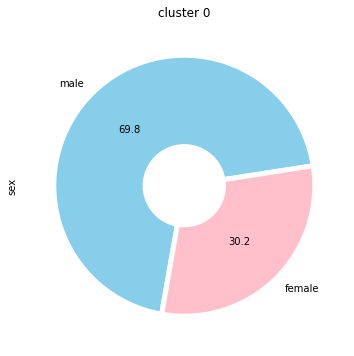

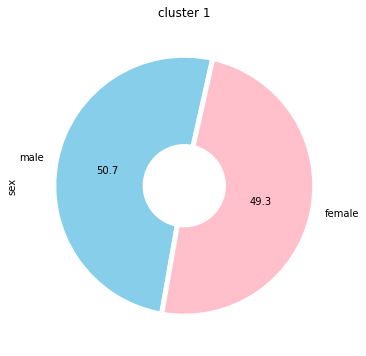

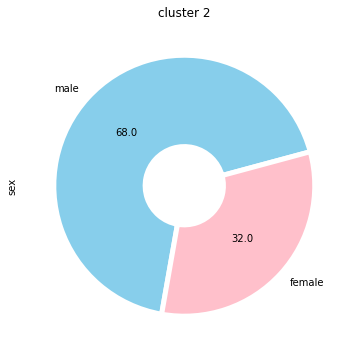

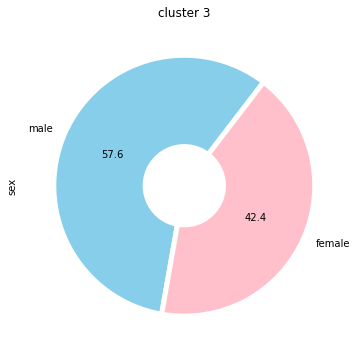

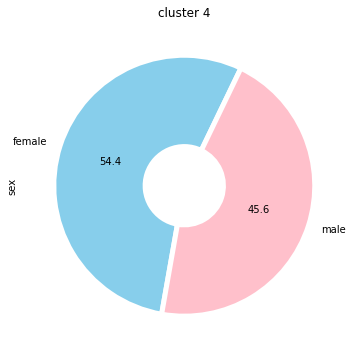

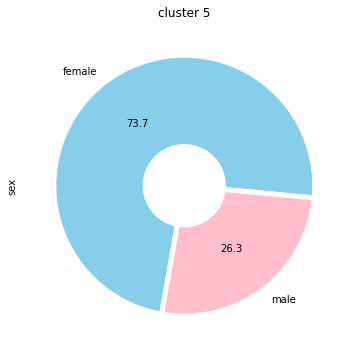

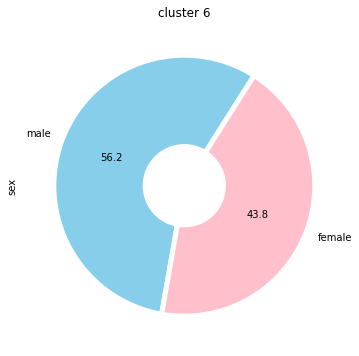

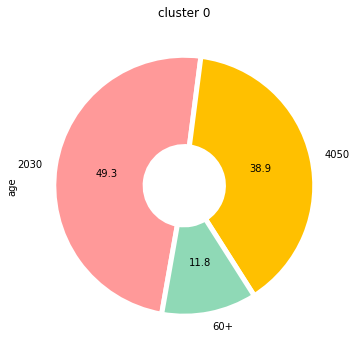

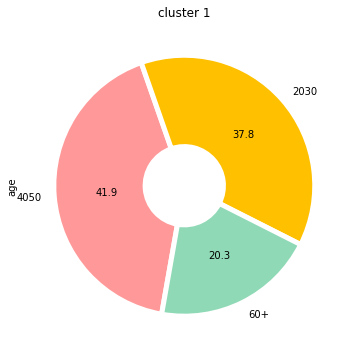

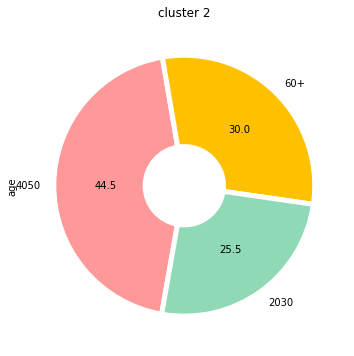

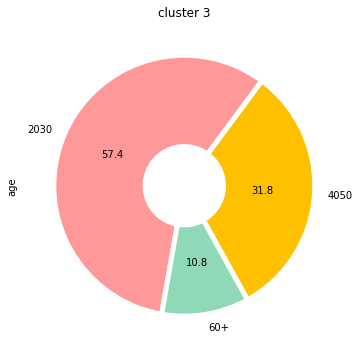

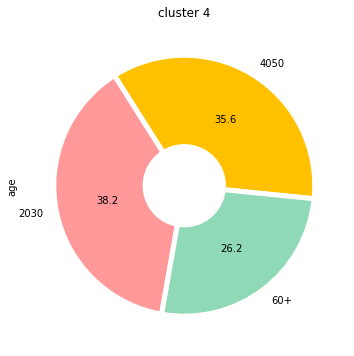

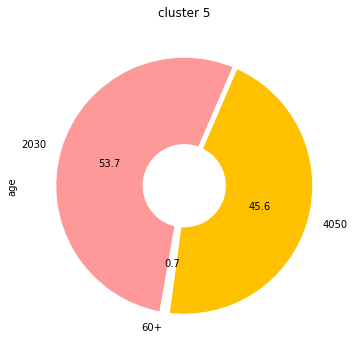

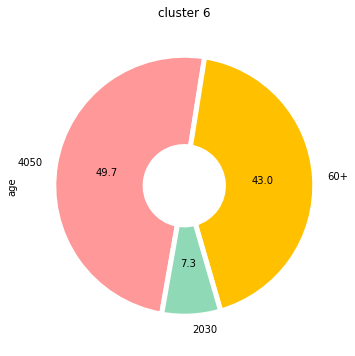

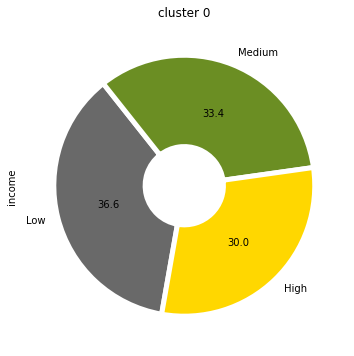

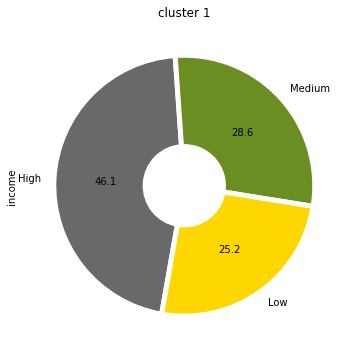

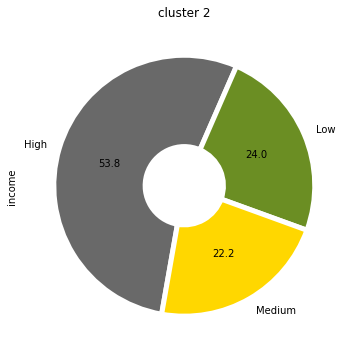

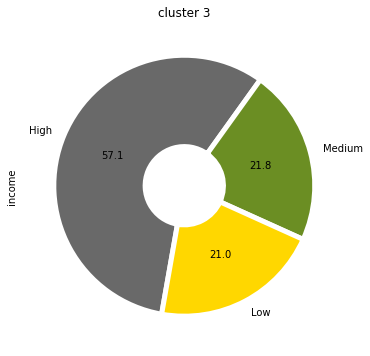

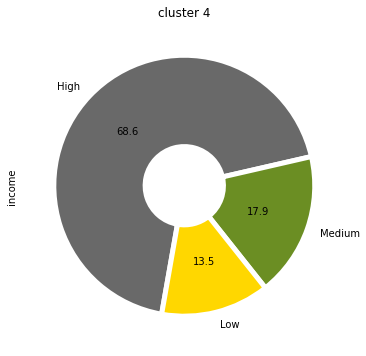

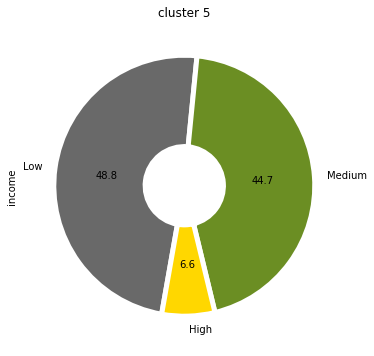

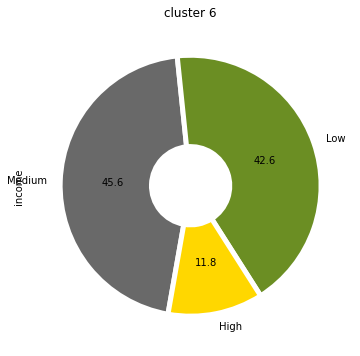

In [ ]:
k = len(df['pred'].unique())



wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0']


def pie_chart(cluster, feature):
  plt.rcParams["figure.figsize"] = (6,6)
  plt.title('cluster {0}'.format(cluster))
  df[df.pred==cluster][feature].value_counts().plot.pie(autopct='%.1f', startangle=260, counterclock=False, colors=colors, wedgeprops=wedgeprops)
  plt.show()

colors = ['skyblue', 'pink']
for c in range(k):
  pie_chart(c, 'sex')

colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0']
for c in range(k):
  pie_chart(c, 'age')

colors = ['dimgrey', 'olivedrab', 'gold']
for c in range(k):
  pie_chart(c, 'income')

#for c in range(k):
#  pie_chart(c, 'month')

# 5) transition 파악
- 분석 대상 그룹: 성별 2개(남,여), 나이 5개(20, 30, 40, 50, 60+), 소득 11개(1~11), 지역207개 = 22770개
- 그룹 비율도 가중치로 반영해야 함
- 그룹 수가 많아서, 중간에 관측 끊기는 경우도 있음 주의


In [ ]:
df = CSVDATA.copy()
df = df[['year', 'month', 'region', 'sex', 'age', 'income','pred']]
print(df.shape)

(268728, 7)


In [ ]:
""" 성별, 나이, 소득 전처리 """

df['sex'] = df['sex'].replace({'남성': 'male', '여성': 'female'})
df['age'] = df['age'].replace({'20대 이하': '20s or less', '30대': '30s', '40대': '40s', '50대': '50s', '60대 이상': '60s or more'})
#df['age'] = df['age'].replace({'20s or less': '2030', '30s': '2030', '40s': '4050', '50s': '4050', '60s or more': '60+'})
#df['income'] = df['income'].replace({'B1':'C1', 'B2':'C1', 'B3':'C2', 'B4':'C2', 'B5':'C3', 'B6':'C3', 'B7':'C4', 'B8':'C4', 'B9':'C5', 'B10':'C5', 'B11':'C5'})

In [ ]:
""" 성별&나이&소득&지역 그룹별 df 생성 """

sex_list = list(df.sex.unique())
age_list = list(df.age.unique())
income_list = list(df.income.unique())
region_list = list(df.region.unique())
for sex in sex_list:
  for age in age_list:
    for income in income_list:
      for region in region_list:
        #print(sex, age, income, region)
        break

count = 0
all_data = []
for sex in sex_list:
  for age in age_list:
    for income in income_list:
      for region in region_list:
        temp = df[df['sex']==sex]
        temp = temp[temp['age']==age]
        temp = temp[temp['income']==income]
        temp = temp[temp['region']==region]
        if temp.empty == True:
          count += 1
        else:
          all_data.append(temp)

print('경우의 수: ', len(all_data)+count )
print('존재: ', len(all_data))
print('미존재: ', count)

경우의 수:  22770
존재:  19217
미존재:  3553


In [ ]:
""" 월별 최다 pred 값 리스트 생성 """

year_list = list(df.year.unique())
month_list = list(df.month.unique())

cluster_dict = {}
for data in all_data: # e.g., male 2030 1 중구 ~ female 60+ 5 광진구
  cluster_list = []
  for year in year_list:
    for month in month_list:

      if (year == 2020) and (month==5):
        break
      else:
        temp = data[data['year']==year]
        temp = temp[temp['month']==month]
        #print(temp.pred.value_counts()) 
        if temp.empty == False:
          cluster_list.append(temp.pred.value_counts().index[0])

  key = data['sex'].unique()[0] + '_' + data['age'].unique()[0] + '_' + data['income'].unique()[0] + '_' + data['region'].unique()[0] 
  cluster_dict[key] = cluster_list
  
cluster_dict

{'male_20s or less_B2_가평군': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0],
 'male_20s or less_B2_강남구': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'male_20s or less_B2_강동구': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'male_20s or less_B2_강릉시': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'male_20s or less_B2_강북구': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'male_20s or less_B2_강서구': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'male_20s or less_B2_강진군': [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'male_20s or less_B2_강화군': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'male_20s or less_B2_거제시': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'male_20s or less_B2_거창군': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'male_20s or less_B2_경산시': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'male_20s or less_B2_경주시': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'male_20s or less_B2_계룡시': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
transition_df = pd.DataFrame(columns = ['state', 'next_state'])

for key, value in cluster_dict.items():
  for i, val in enumerate(value[:-1]): # We don't care about last state
    df_stg = pd.DataFrame(index=[0])
    df_stg['state'], df_stg['next_state'] = value[i], value[i+1]
    transition_df = pd.concat([transition_df, df_stg], axis = 0)
print('total number of transitions: ', len(transition_df)) # 예를들어 16개월동안 모두 값이 존재했으면 15 transitions
cross_tab = pd.crosstab(transition_df['state'], transition_df['next_state'])
transition_matrix = cross_tab.div(cross_tab.sum(axis=1), axis=0)
transition_matrix

total number of transitions:  249511


next_state,0,1,2,3,4,5,6
state,,,,,,,
0,0.792627,0.021576,0.060737,0.007808,0.007567,0.025338,0.084347
1,0.082670,0.779505,0.071144,0.016315,0.033360,0.006169,0.010836
2,0.168287,0.054379,0.673119,0.019086,0.041231,0.006422,0.037475
3,0.187972,0.122603,0.176932,0.374782,0.128704,0.003196,0.005811
4,0.116605,0.142499,0.227030,0.074507,0.428834,0.003341,0.007183
5,0.076394,0.004736,0.006650,0.000487,0.000616,0.863529,0.047588
6,0.130612,0.004588,0.020528,0.000515,0.000947,0.021990,0.820820


In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd

print('total transitions: ', len(transition_df), '\n') # 예를들어 16개월동안 모두 값이 존재했으면 15 transitions

cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(transition_matrix)
x=x.style.background_gradient(cmap=cm)
display(x)

total transitions:  249511 



next_state,0,1,2,3,4,5,6
state,,,,,,,
0,0.792627,0.021576,0.060737,0.007808,0.007567,0.025338,0.084347
1,0.082670,0.779505,0.071144,0.016315,0.033360,0.006169,0.010836
2,0.168287,0.054379,0.673119,0.019086,0.041231,0.006422,0.037475
3,0.187972,0.122603,0.176932,0.374782,0.128704,0.003196,0.005811
4,0.116605,0.142499,0.227030,0.074507,0.428834,0.003341,0.007183
5,0.076394,0.004736,0.006650,0.000487,0.000616,0.863529,0.047588
6,0.130612,0.004588,0.020528,0.000515,0.000947,0.021990,0.820820


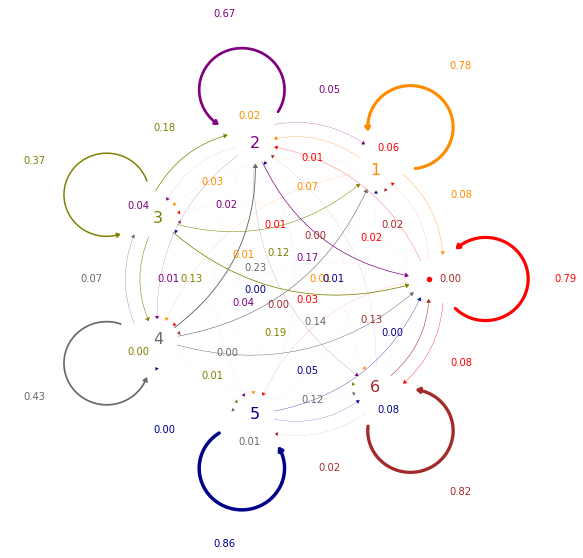

In [ ]:
!pip install hmmviz
from hmmviz import TransGraph
graph = TransGraph(transition_matrix)

fig = plt.figure(figsize=(10, 10))

colors = {0: 'red', 1: 'darkorange', 2: 'purple', 3: 'olive', 4:'dimgrey',
          5: 'darkblue', 6:'brown', 7:'black'}

#     ["dodgerblue", "deepskyblue", "lightskyblue", "lightblue", "paleturquoise",
#     "sienna", "orangered", "tomato", "coral", "darksalmon", "salmon", "lightsalmon", "mistyrose",
#     "darkgreen", "green", "seagreen", "mediumseagreen", "darkseagreen", "lightgreen", "palegreen",
#     "rebeccapurple", "blueviolet", "darkorchid", "mediumorchid", "mediumpurple", "plum", "thistle",
#     "dimgrey", "grey", "darkgrey", "silver", "lightgrey", "whitesmoke"
#     'darkgoldenrod','goldenrod','olive','darkkhaki', 'gold' ,'khaki']

graph.draw( nodecolors=colors, edgecolors=colors, edgelabels=True,
    nodefontsize=16,
)

plt.show()

In [ ]:
a = 3